# Analytics - Product Quality

#### Date: 2023/07

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: DNIT

##### Semester: 2023/01
##### Professor: Hilmer Neri

##### Members:

- Antônio Ferreira de Castro Neto
- Artur Rodrigues
- Carolina
- Denys Rogeres
- Felipe Augustini
- Guilherme Soares
- Isadora da Cruz Galvão
- João Gabriel de Campos
- Julia Souza
- Letícia
- Lucas Rodrigues Fonseca
- Mateus Orlando
- Miguel de Frias
- Pedro Braga
- Ricardo Augusto
- Yan Andrade
- Yan Luca




### LIBRARIES

In [280]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [281]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [282]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [283]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-1-Dnit-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'EscolaService': 'cs',
    'UsuarioService': 'cs',
    'UpsService': 'cs',
    'Front': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [284]:
# Maybe you should change this path to your own path

sonar_files = glob('./analytics-raw-data/*.json')

## Create DataFrame

#### Unmarshall json

In [285]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [286]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [287]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [288]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [289]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [290]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [291]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2023-1-Dnit-EscolaService',
       'fga-eps-mds-2023-1-Dnit-Front',
       'fga-eps-mds-2023-1-Dnit-UpsService',
       'fga-eps-mds-2023-1-Dnit-UsuarioService'], dtype=object)

### Create dataframe per repository

In [292]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [293]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [294]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [295]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [296]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [297]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [298]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [299]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [300]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [301]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

## Data visualization

In this area you will need to plot the metrics of each repository.

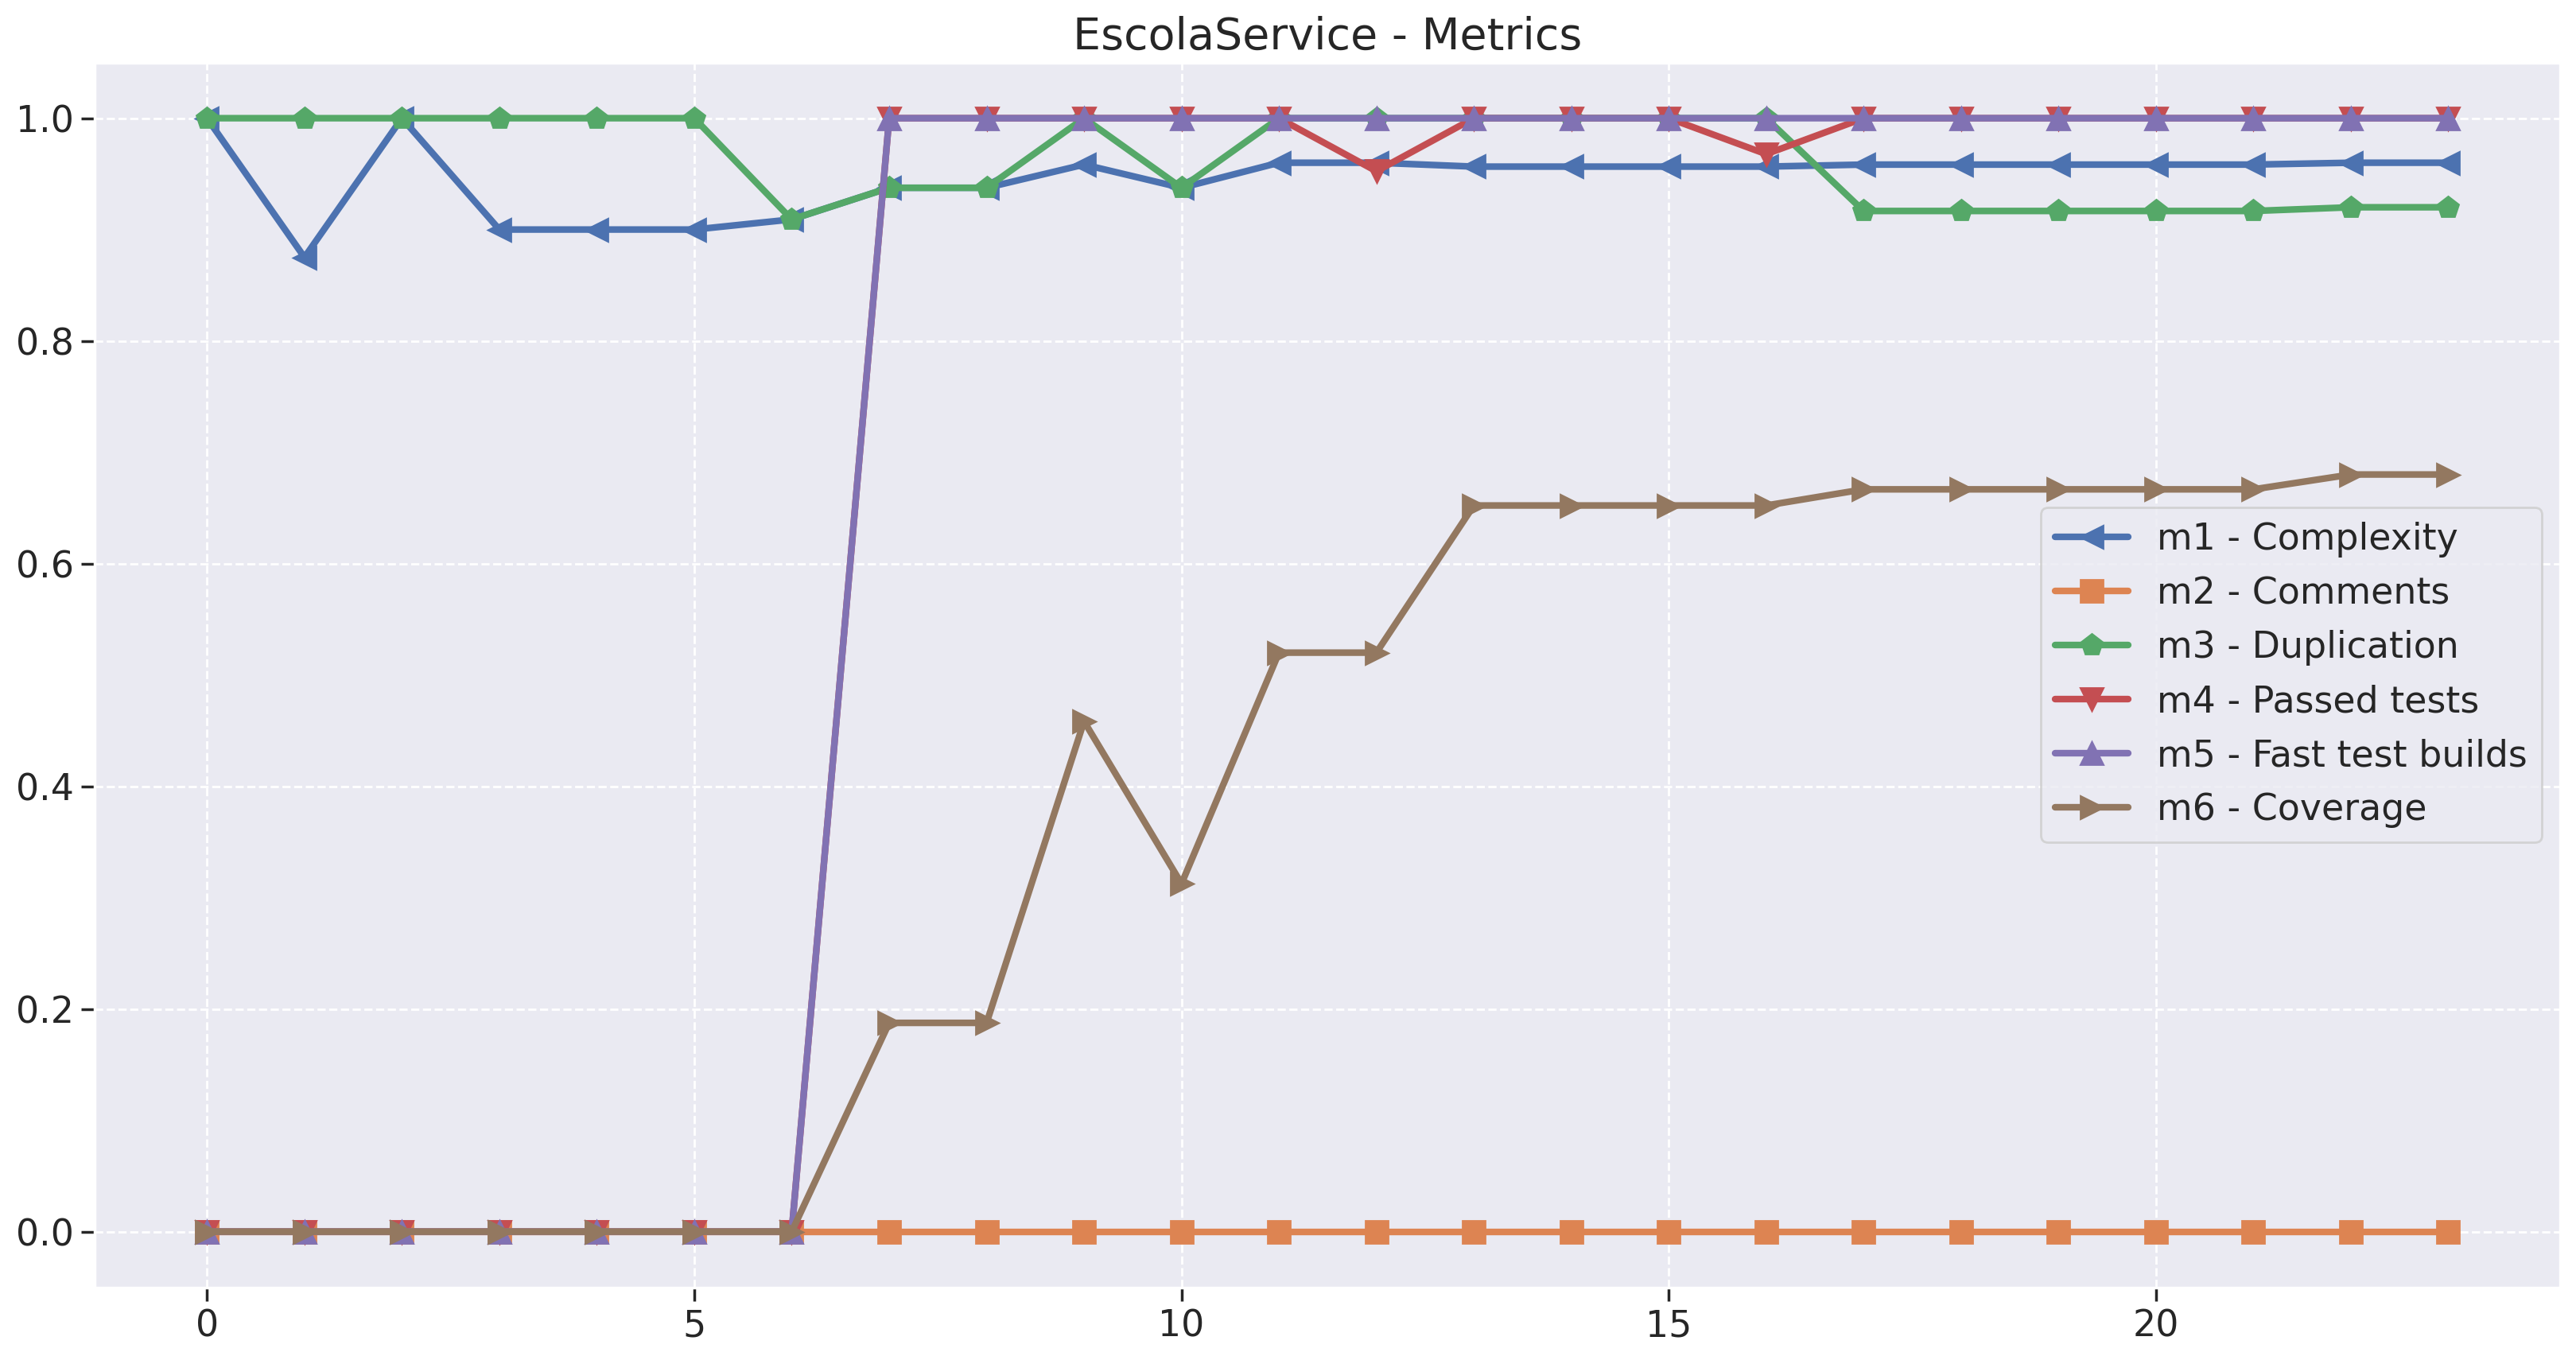

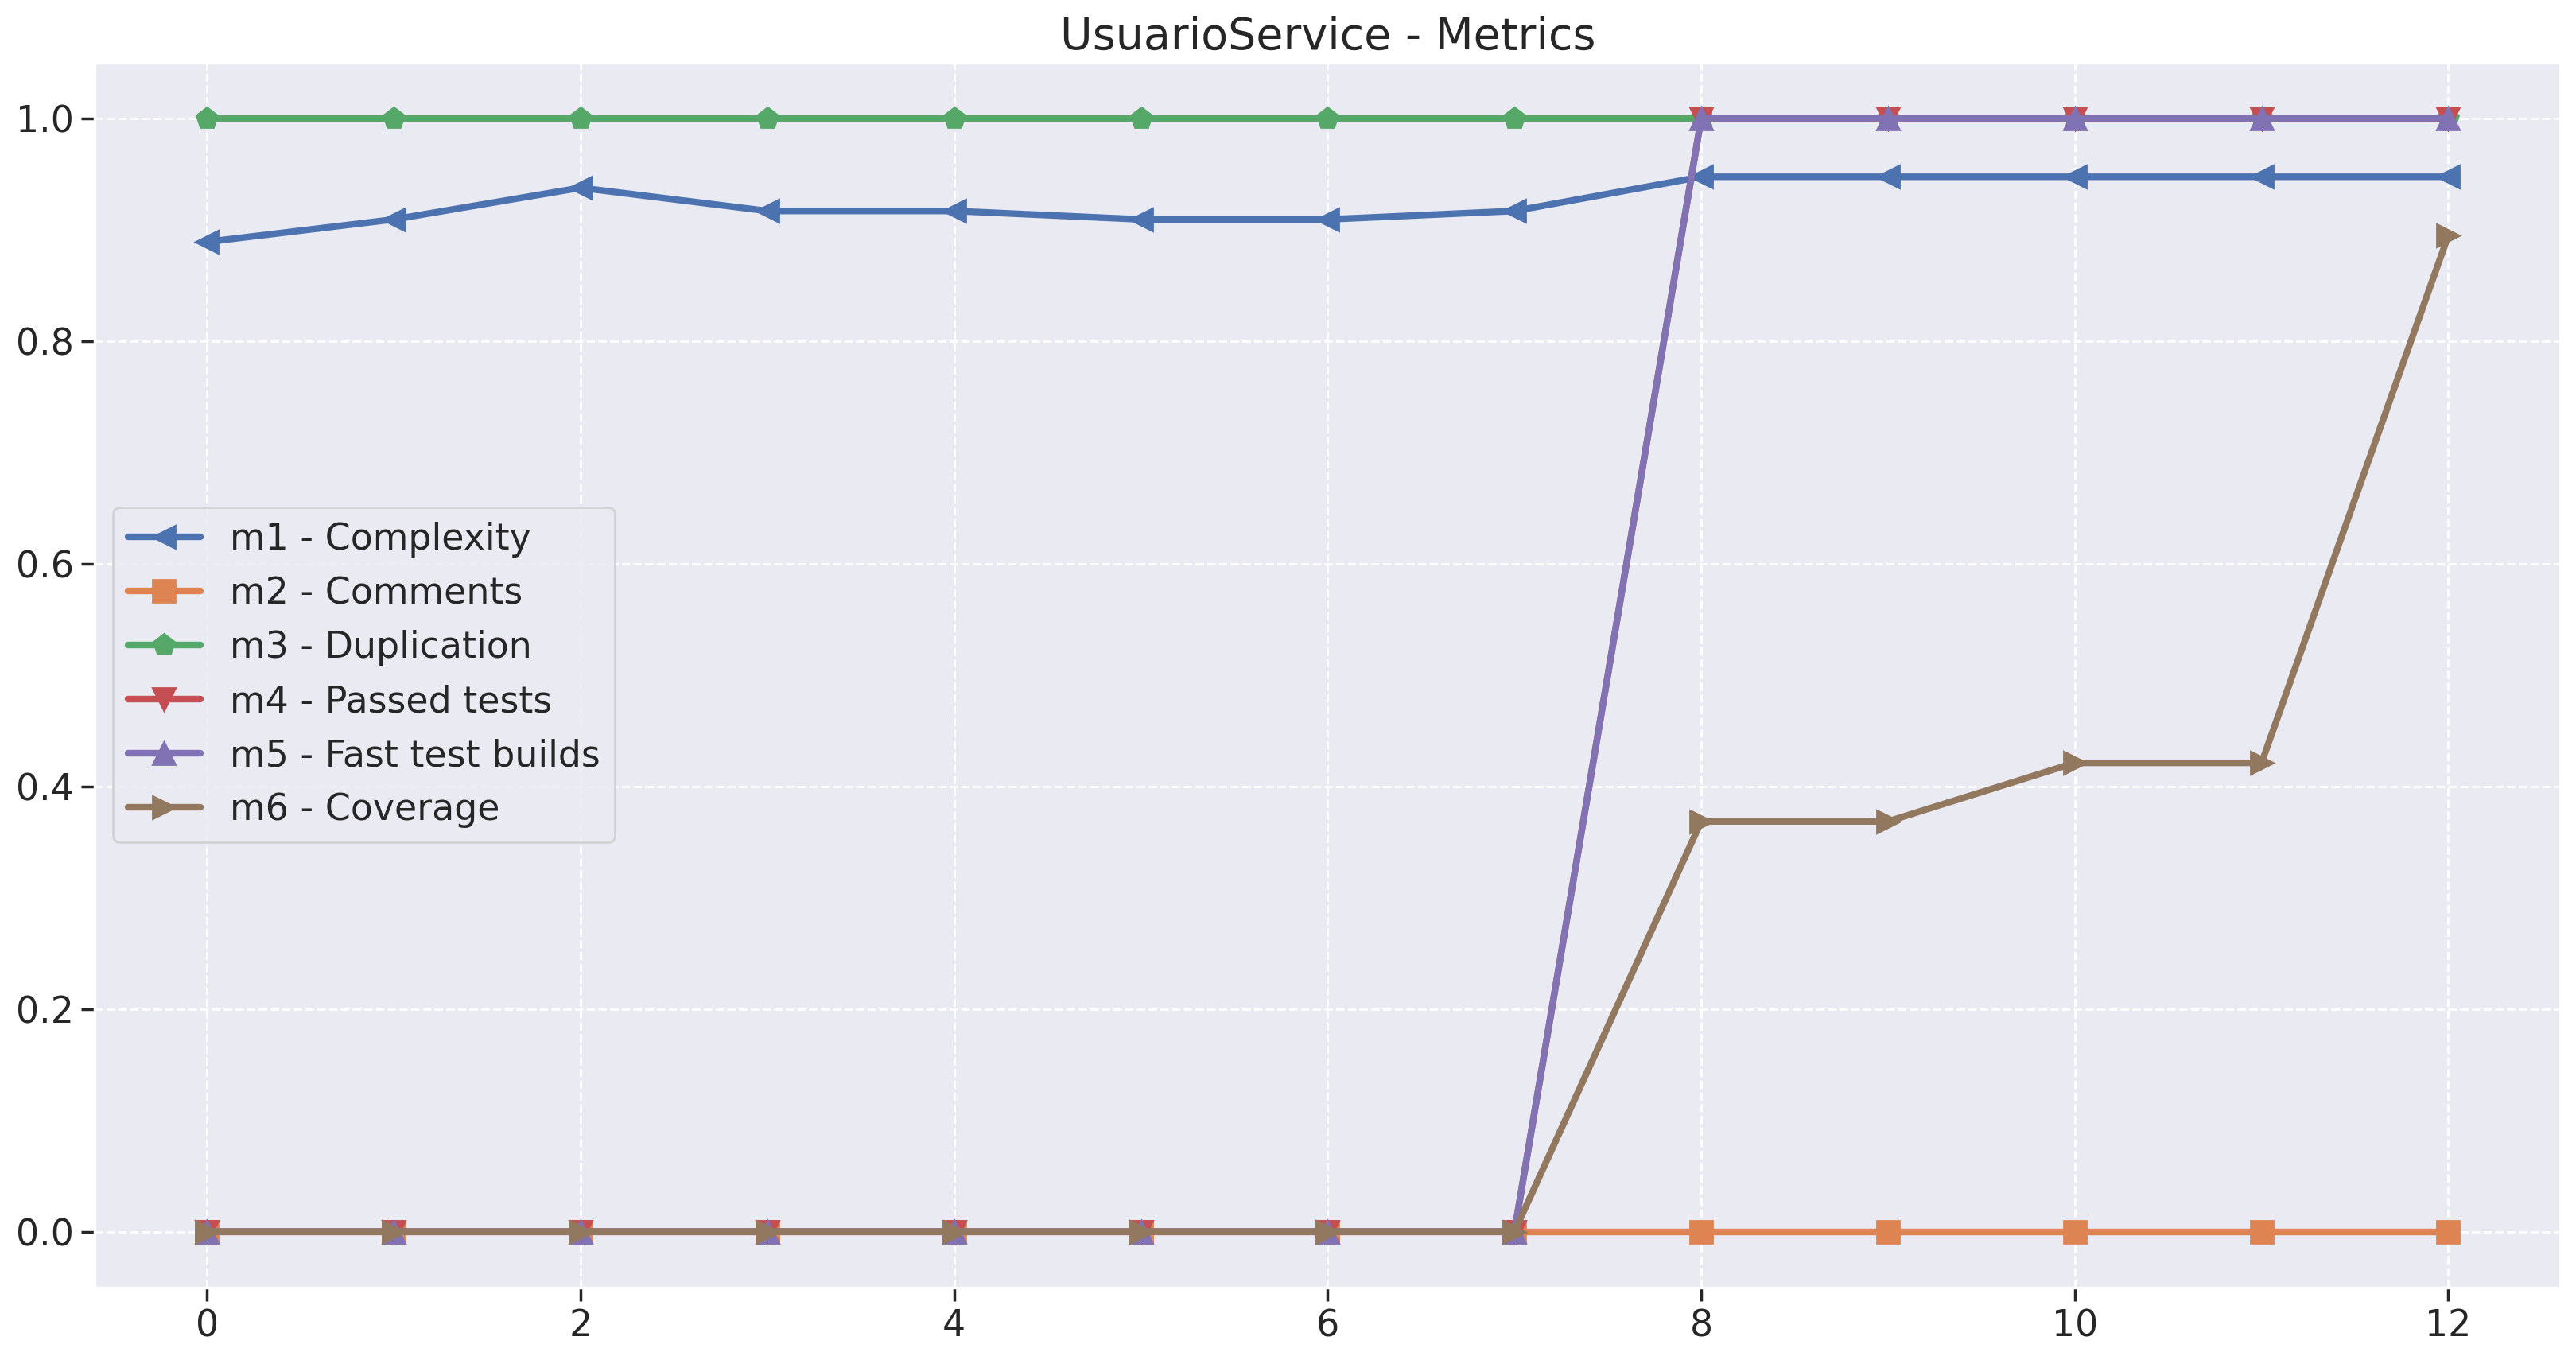

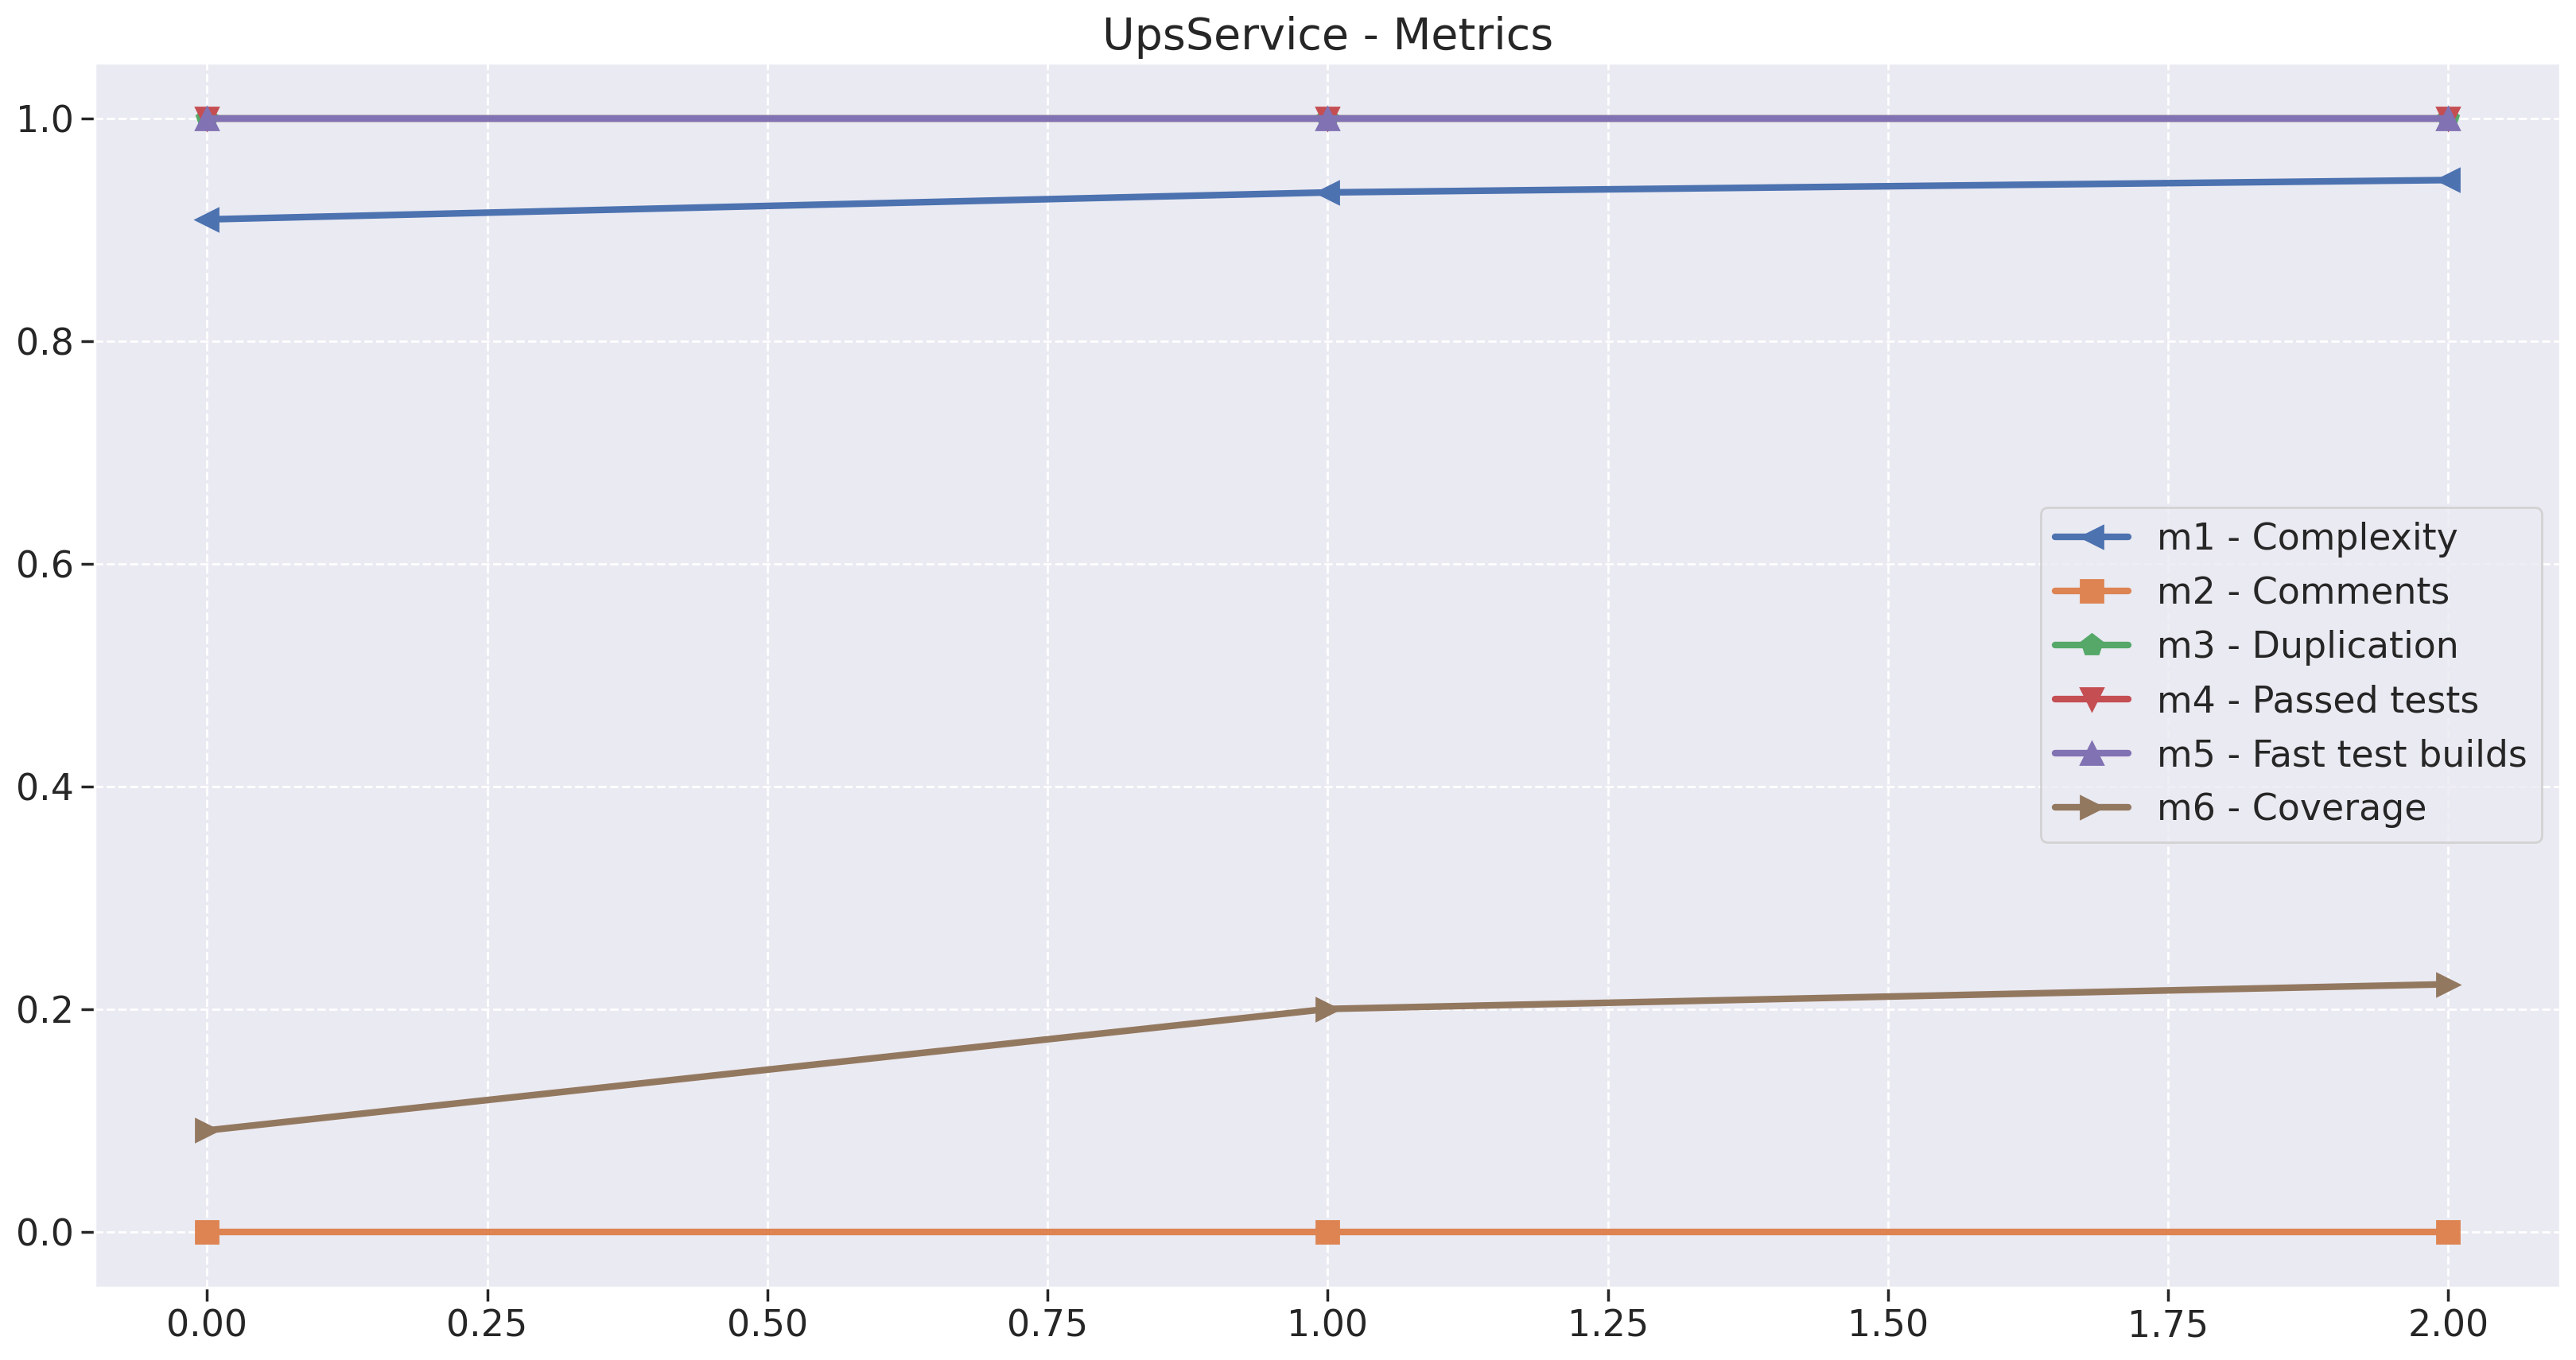

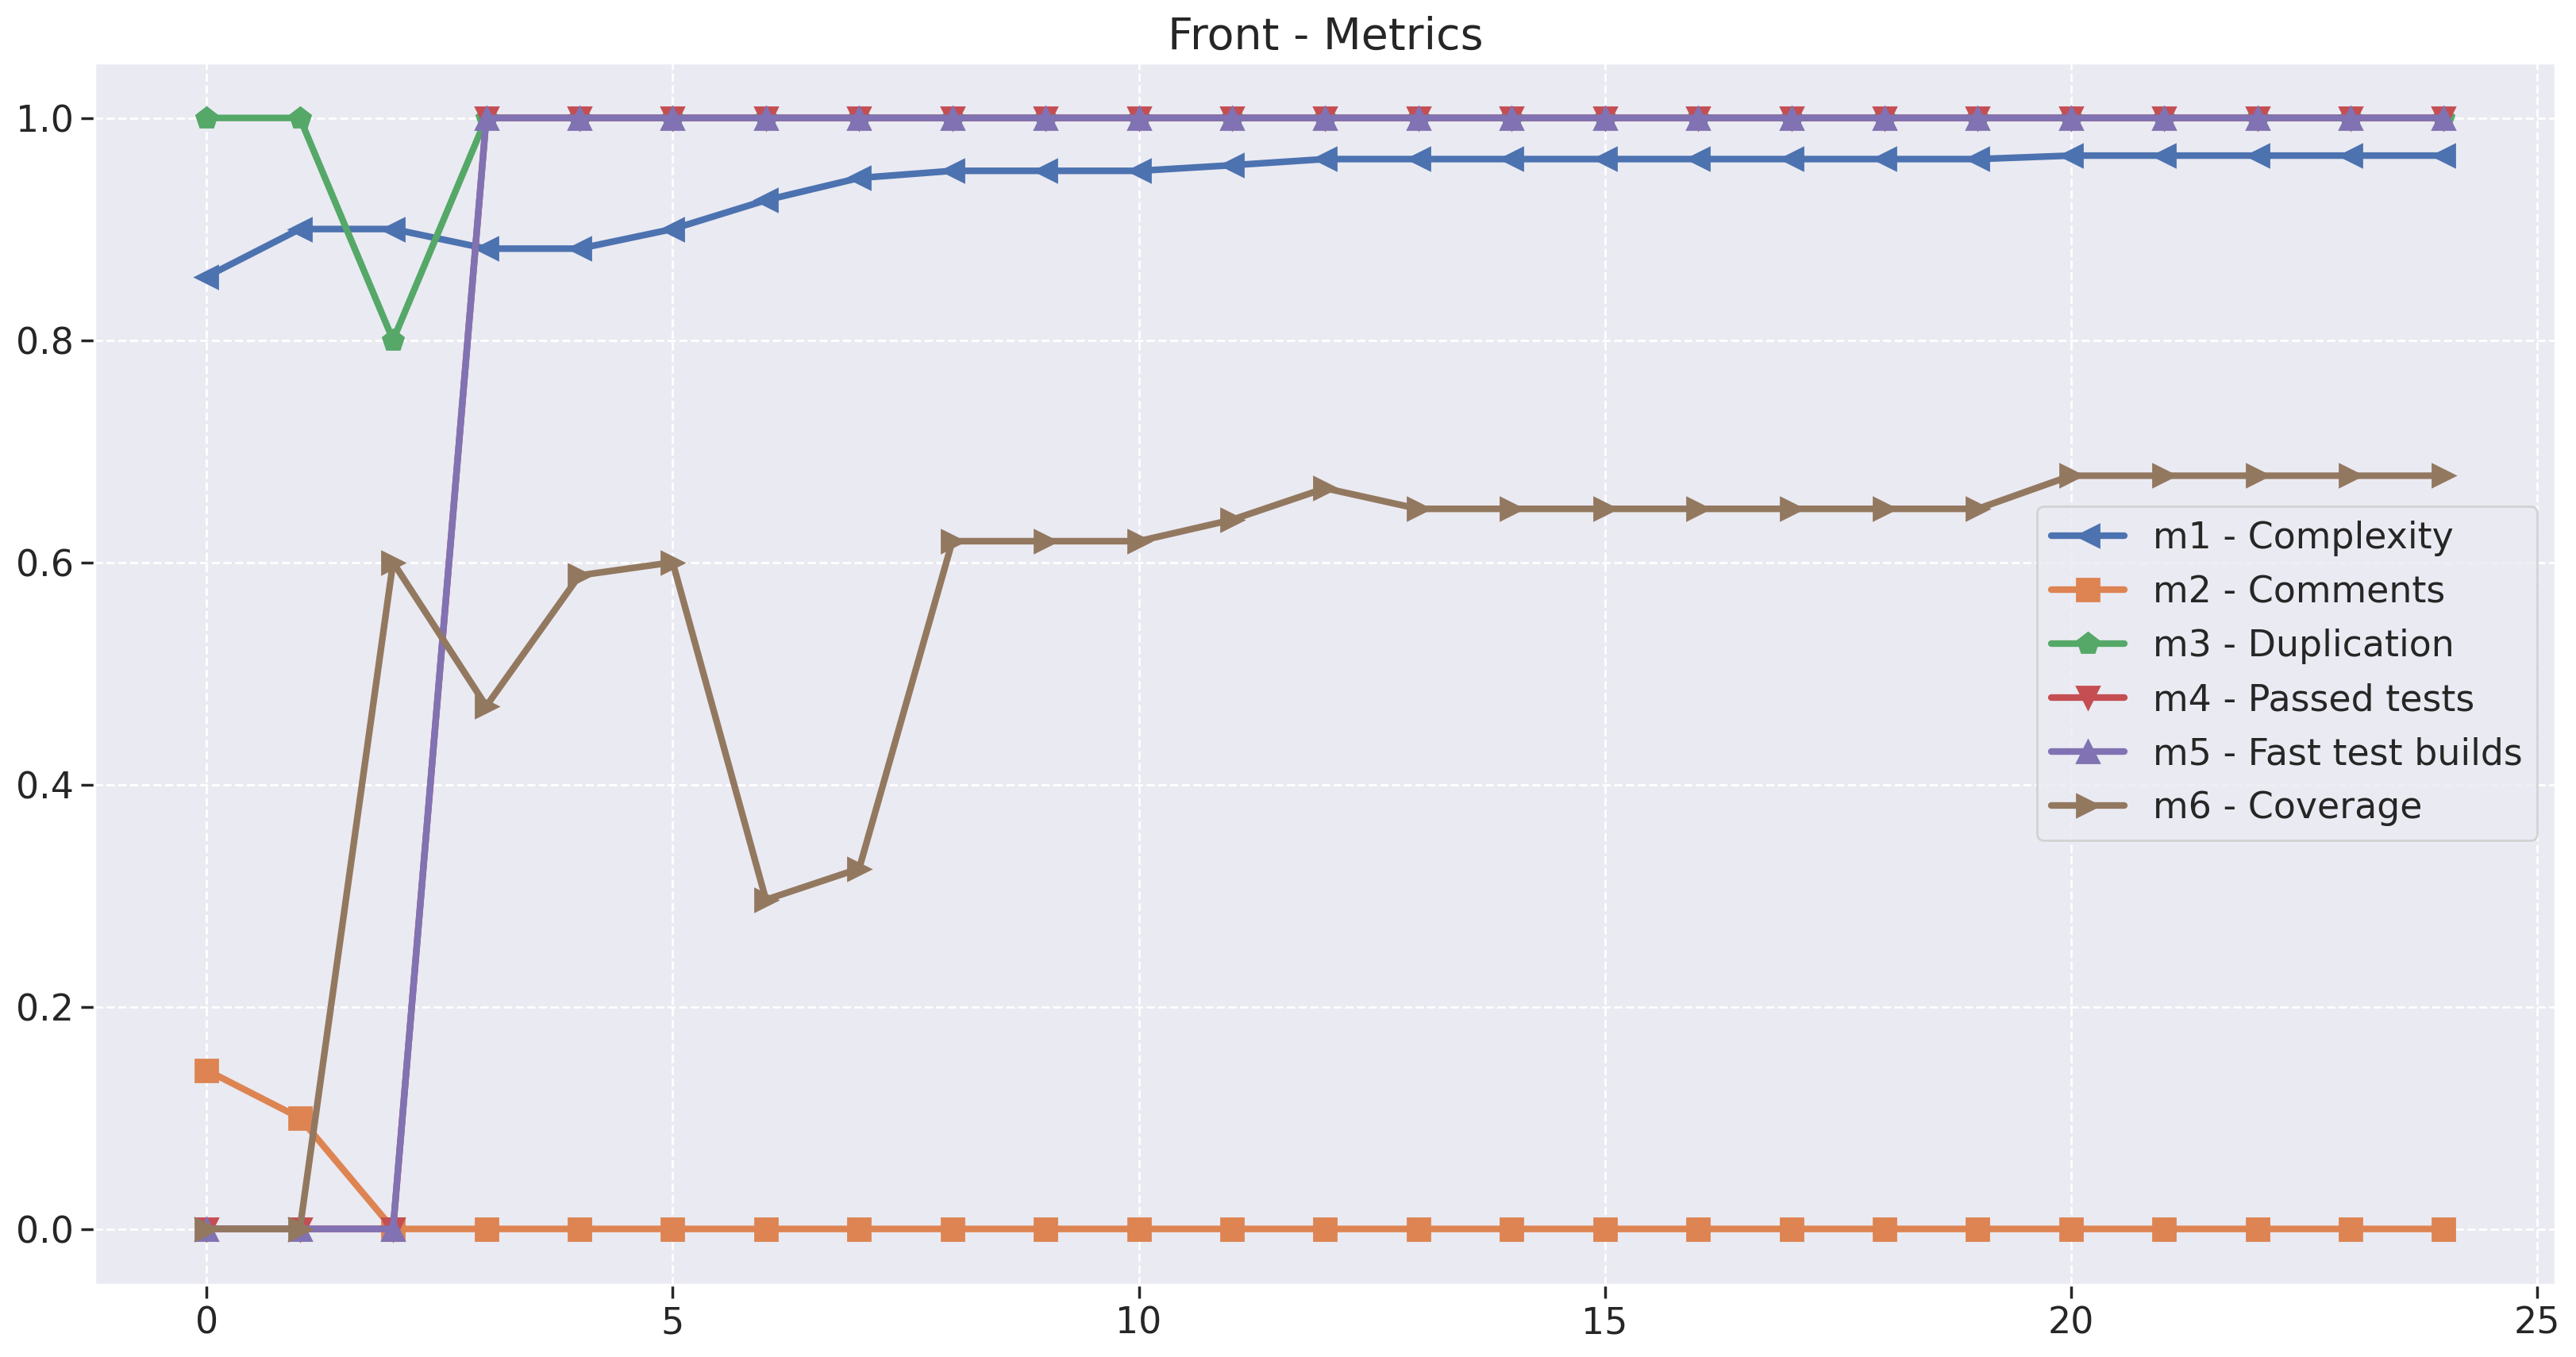

In [302]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [303]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

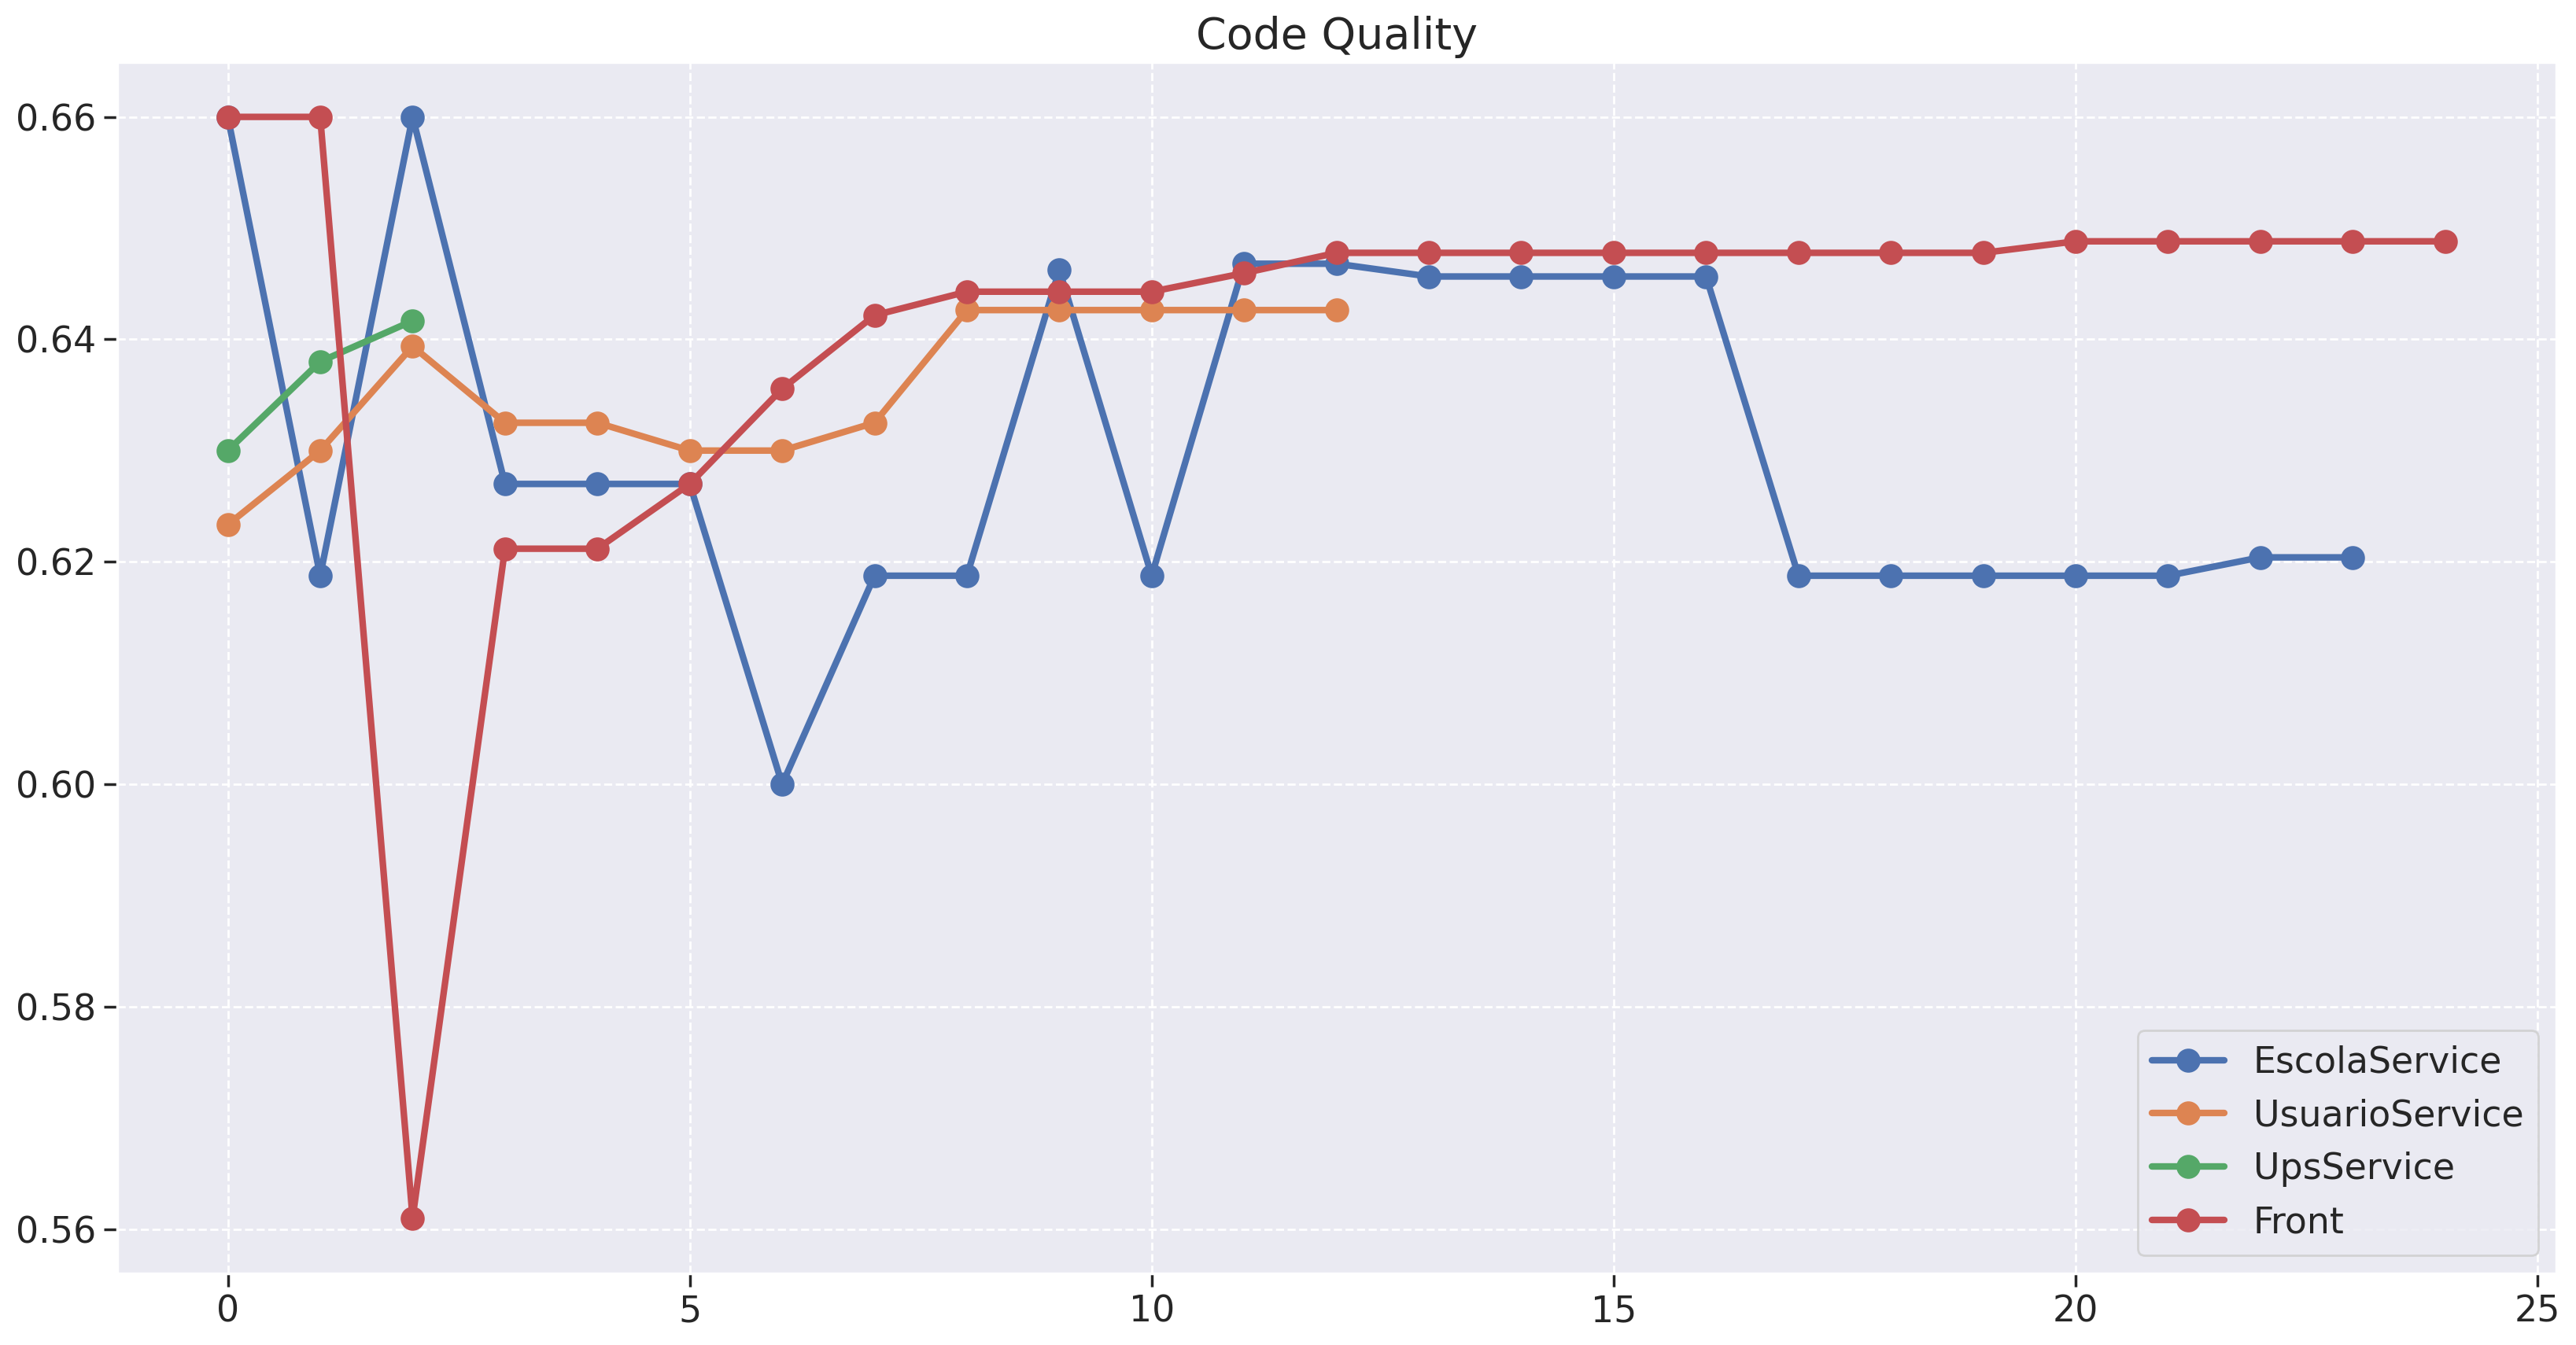

In [304]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

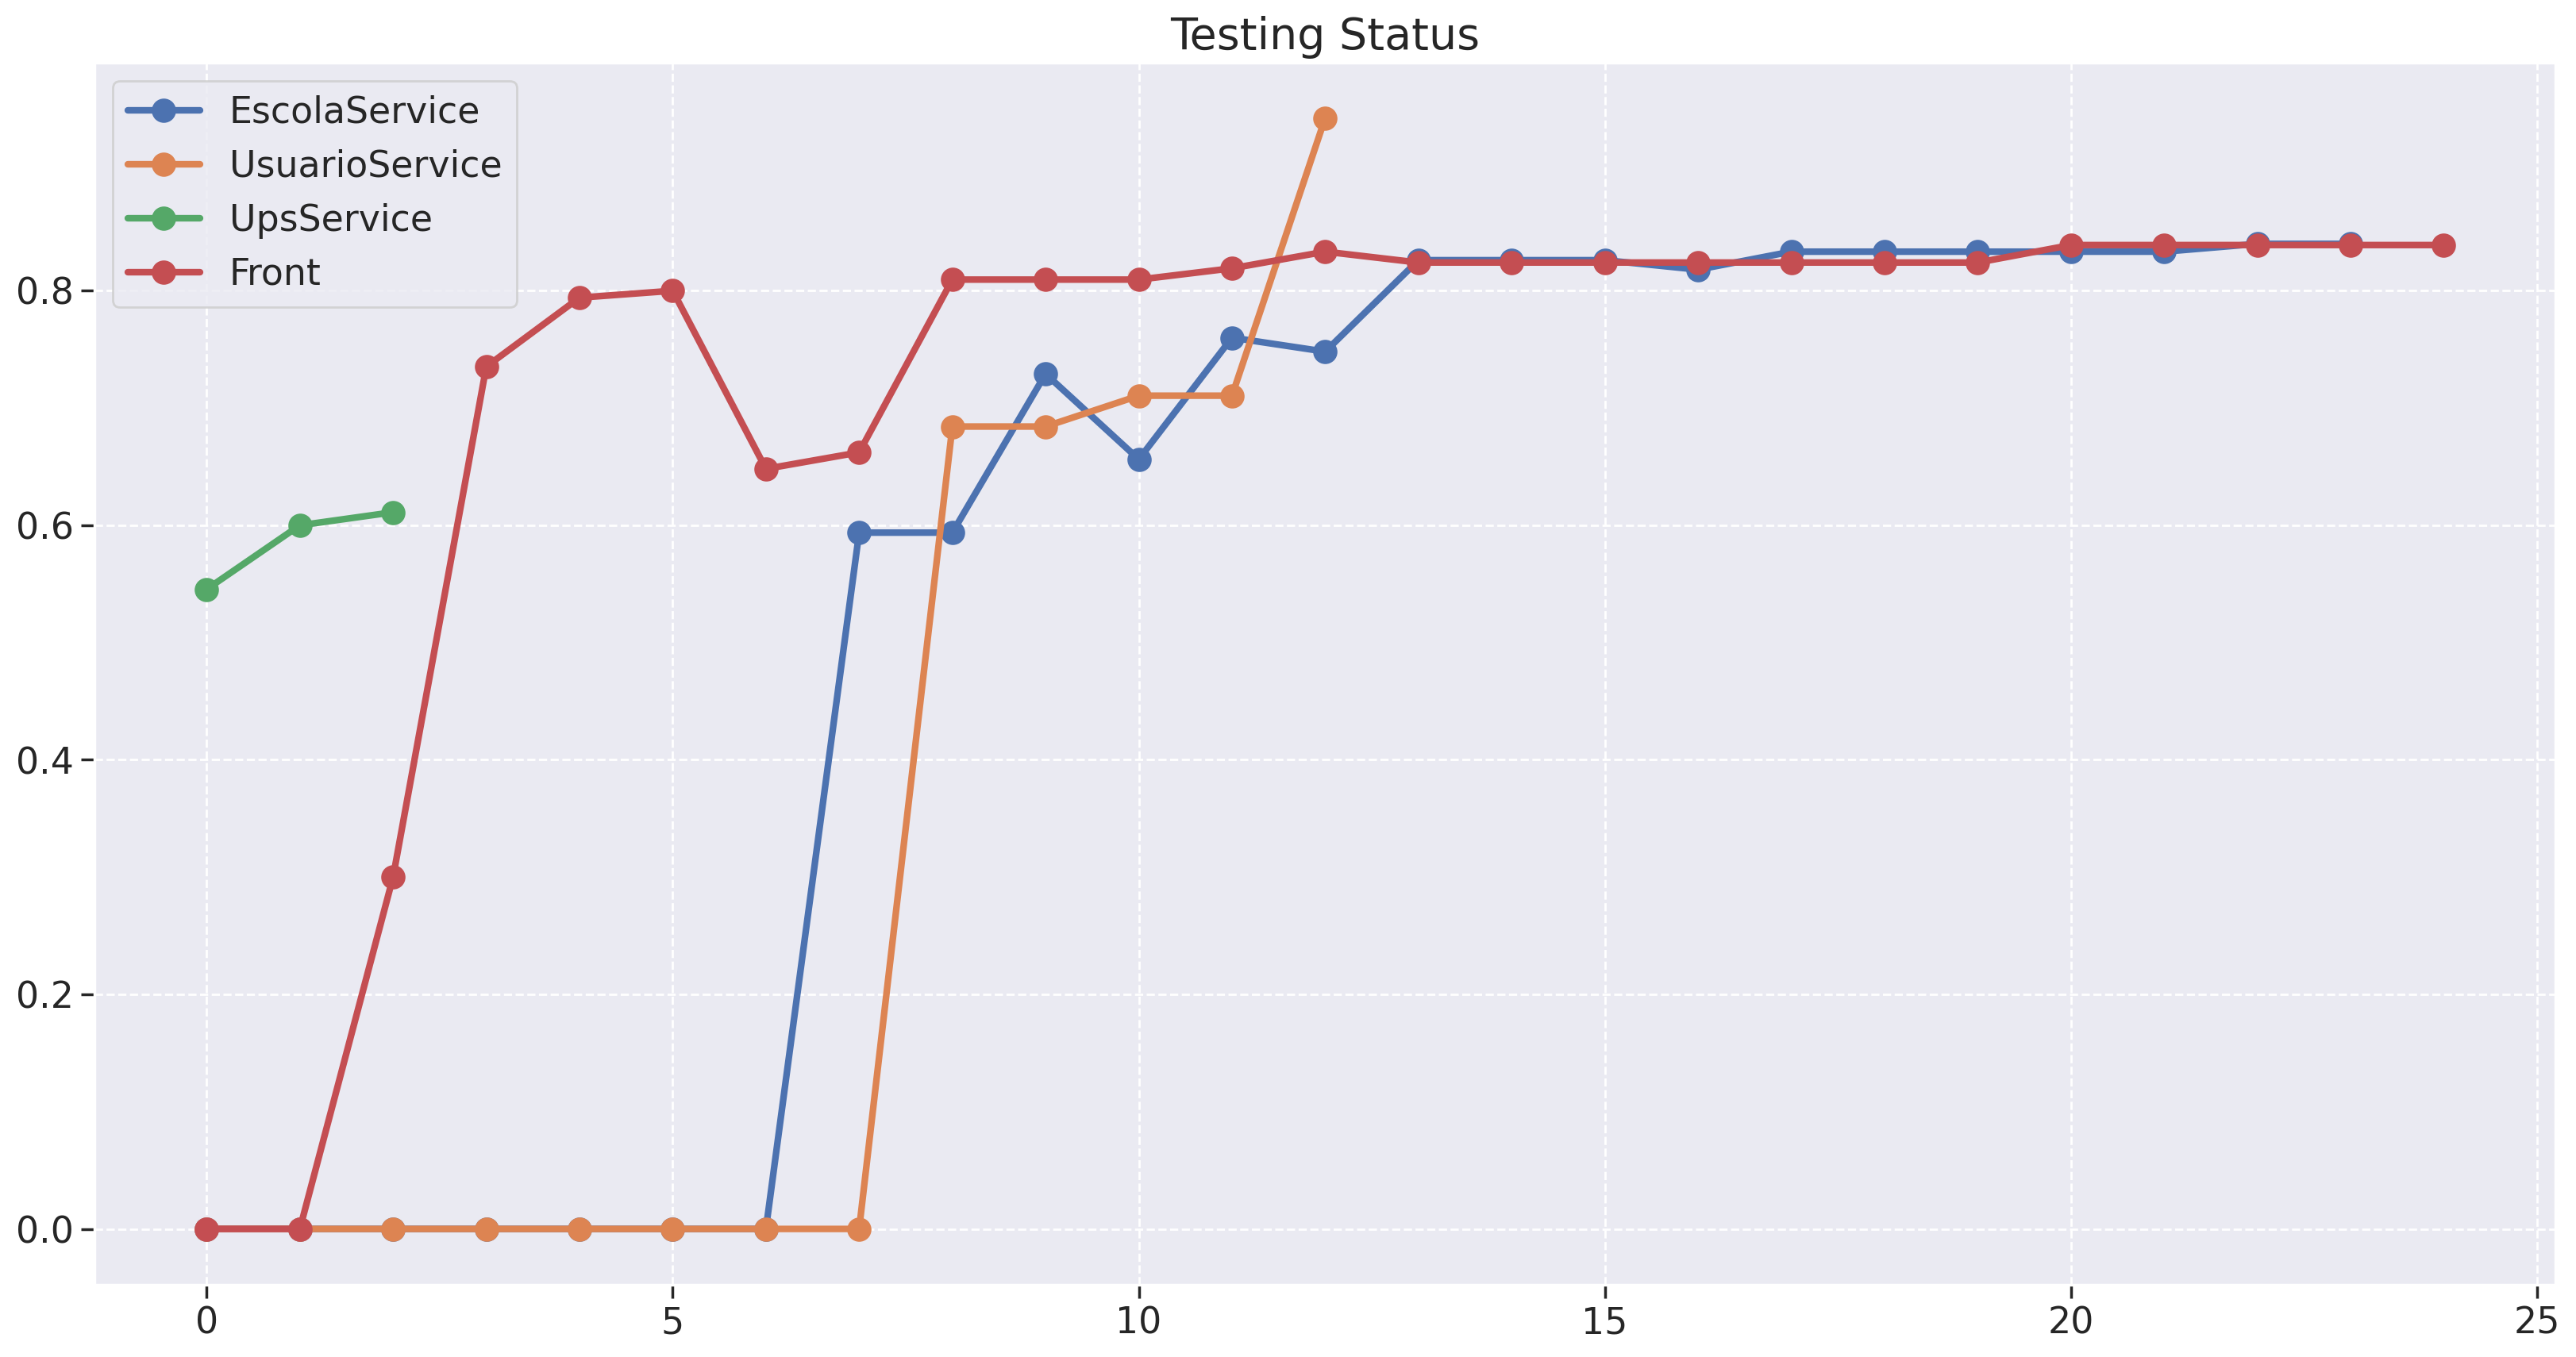

In [305]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [306]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [307]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [308]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

EscolaService
Maintainability Stats
    mean     mode  median      std      var  min  max
0.315271 0.309375 0.31185 0.007975 0.000064  0.3 0.33
Reliability Stats
    mean  mode   median    std      var  min  max
0.275499   0.0 0.377024 0.1841 0.033893  0.0 0.42


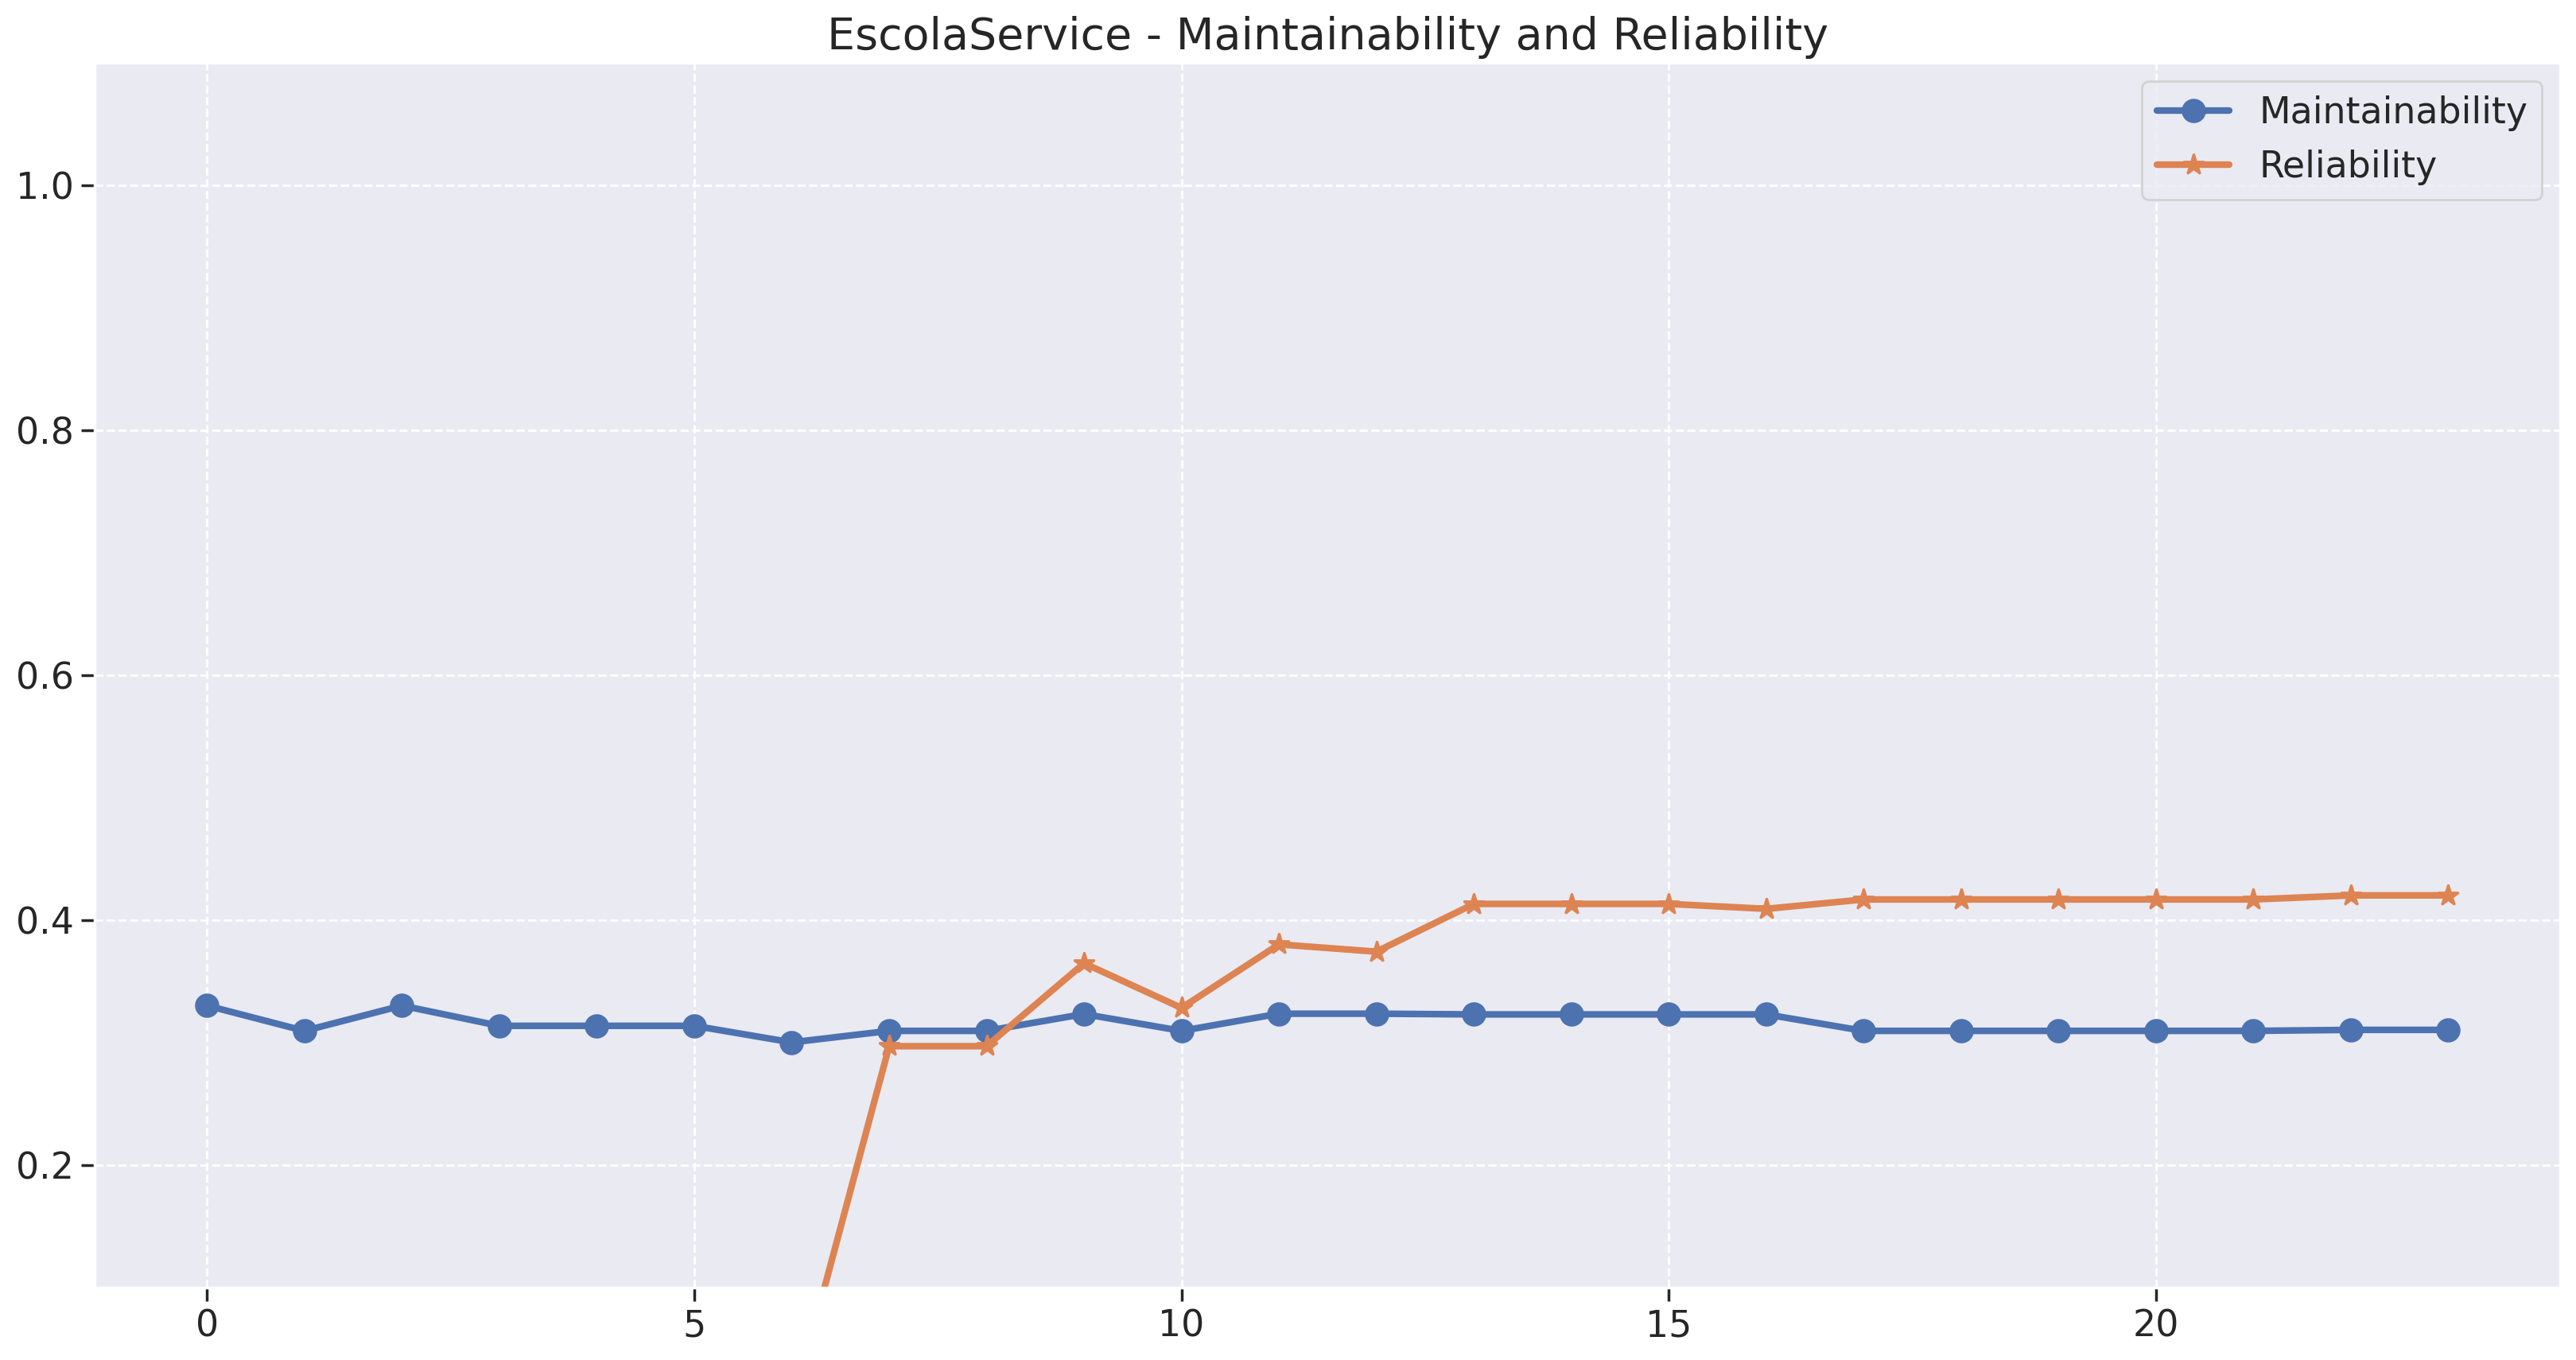

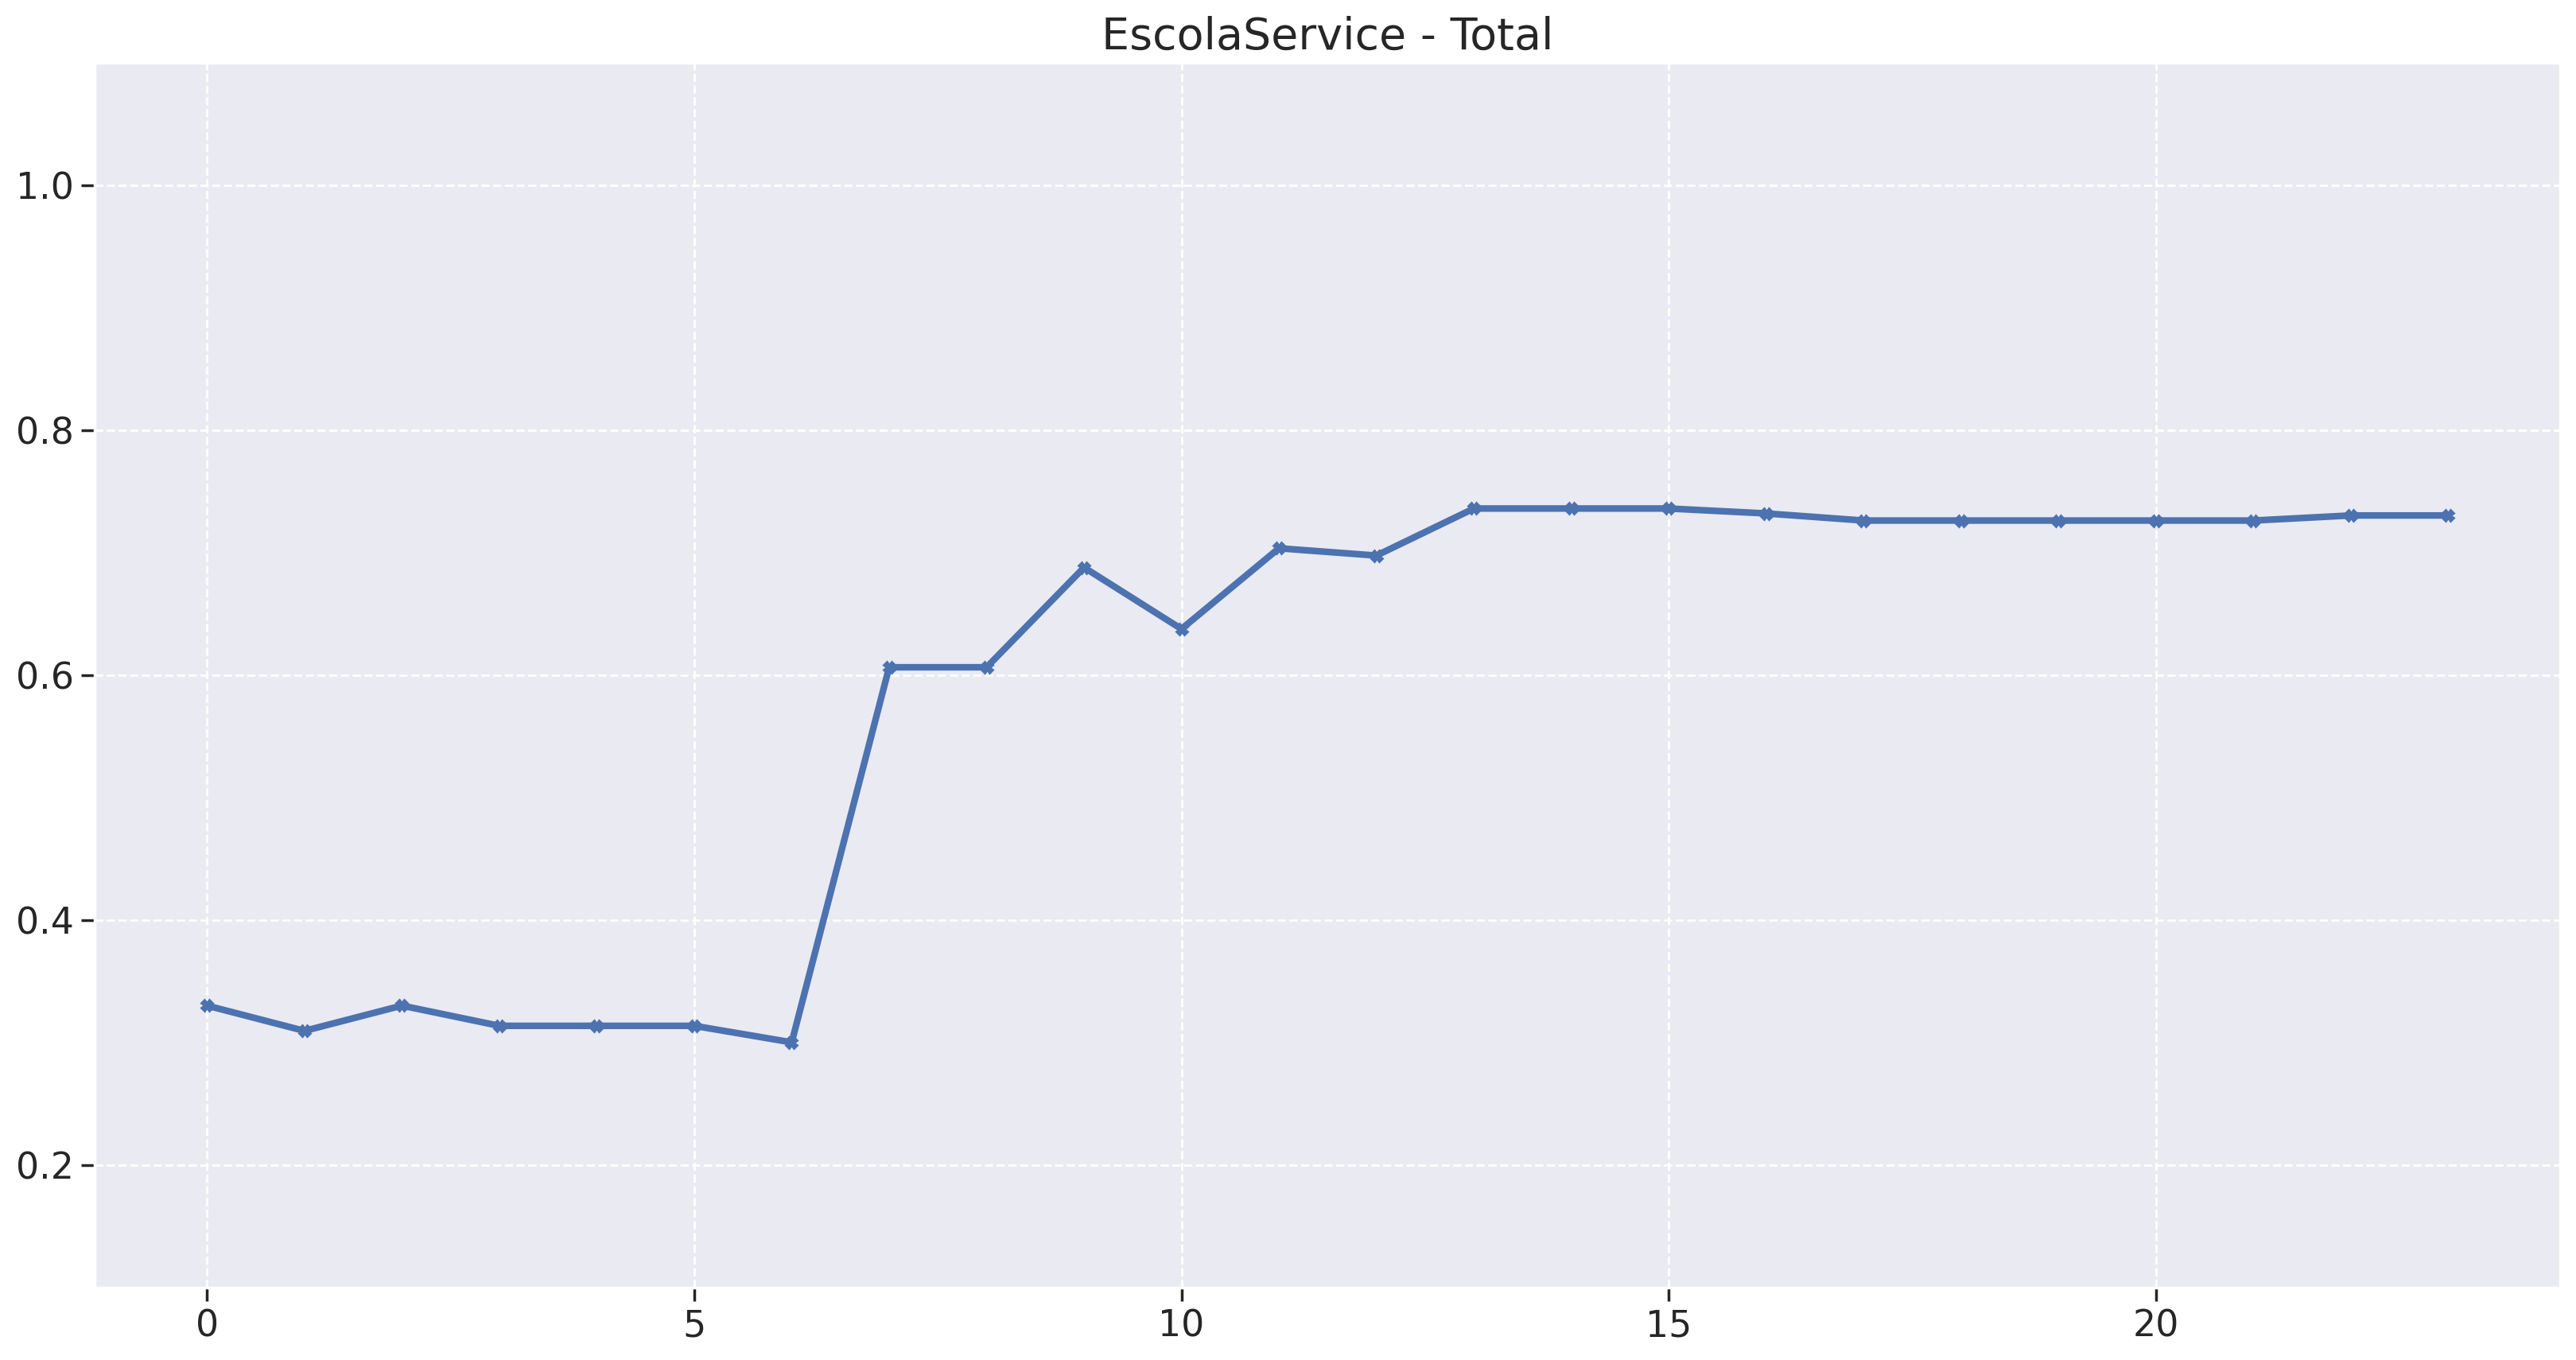

UsuarioService
Maintainability Stats
    mean     mode  median      std      var      min      max
0.317822 0.321316 0.31625 0.003338 0.000011 0.311667 0.321316
Reliability Stats
    mean  mode  median      std      var  min      max
0.143725   0.0     0.0 0.191993 0.036861  0.0 0.473684


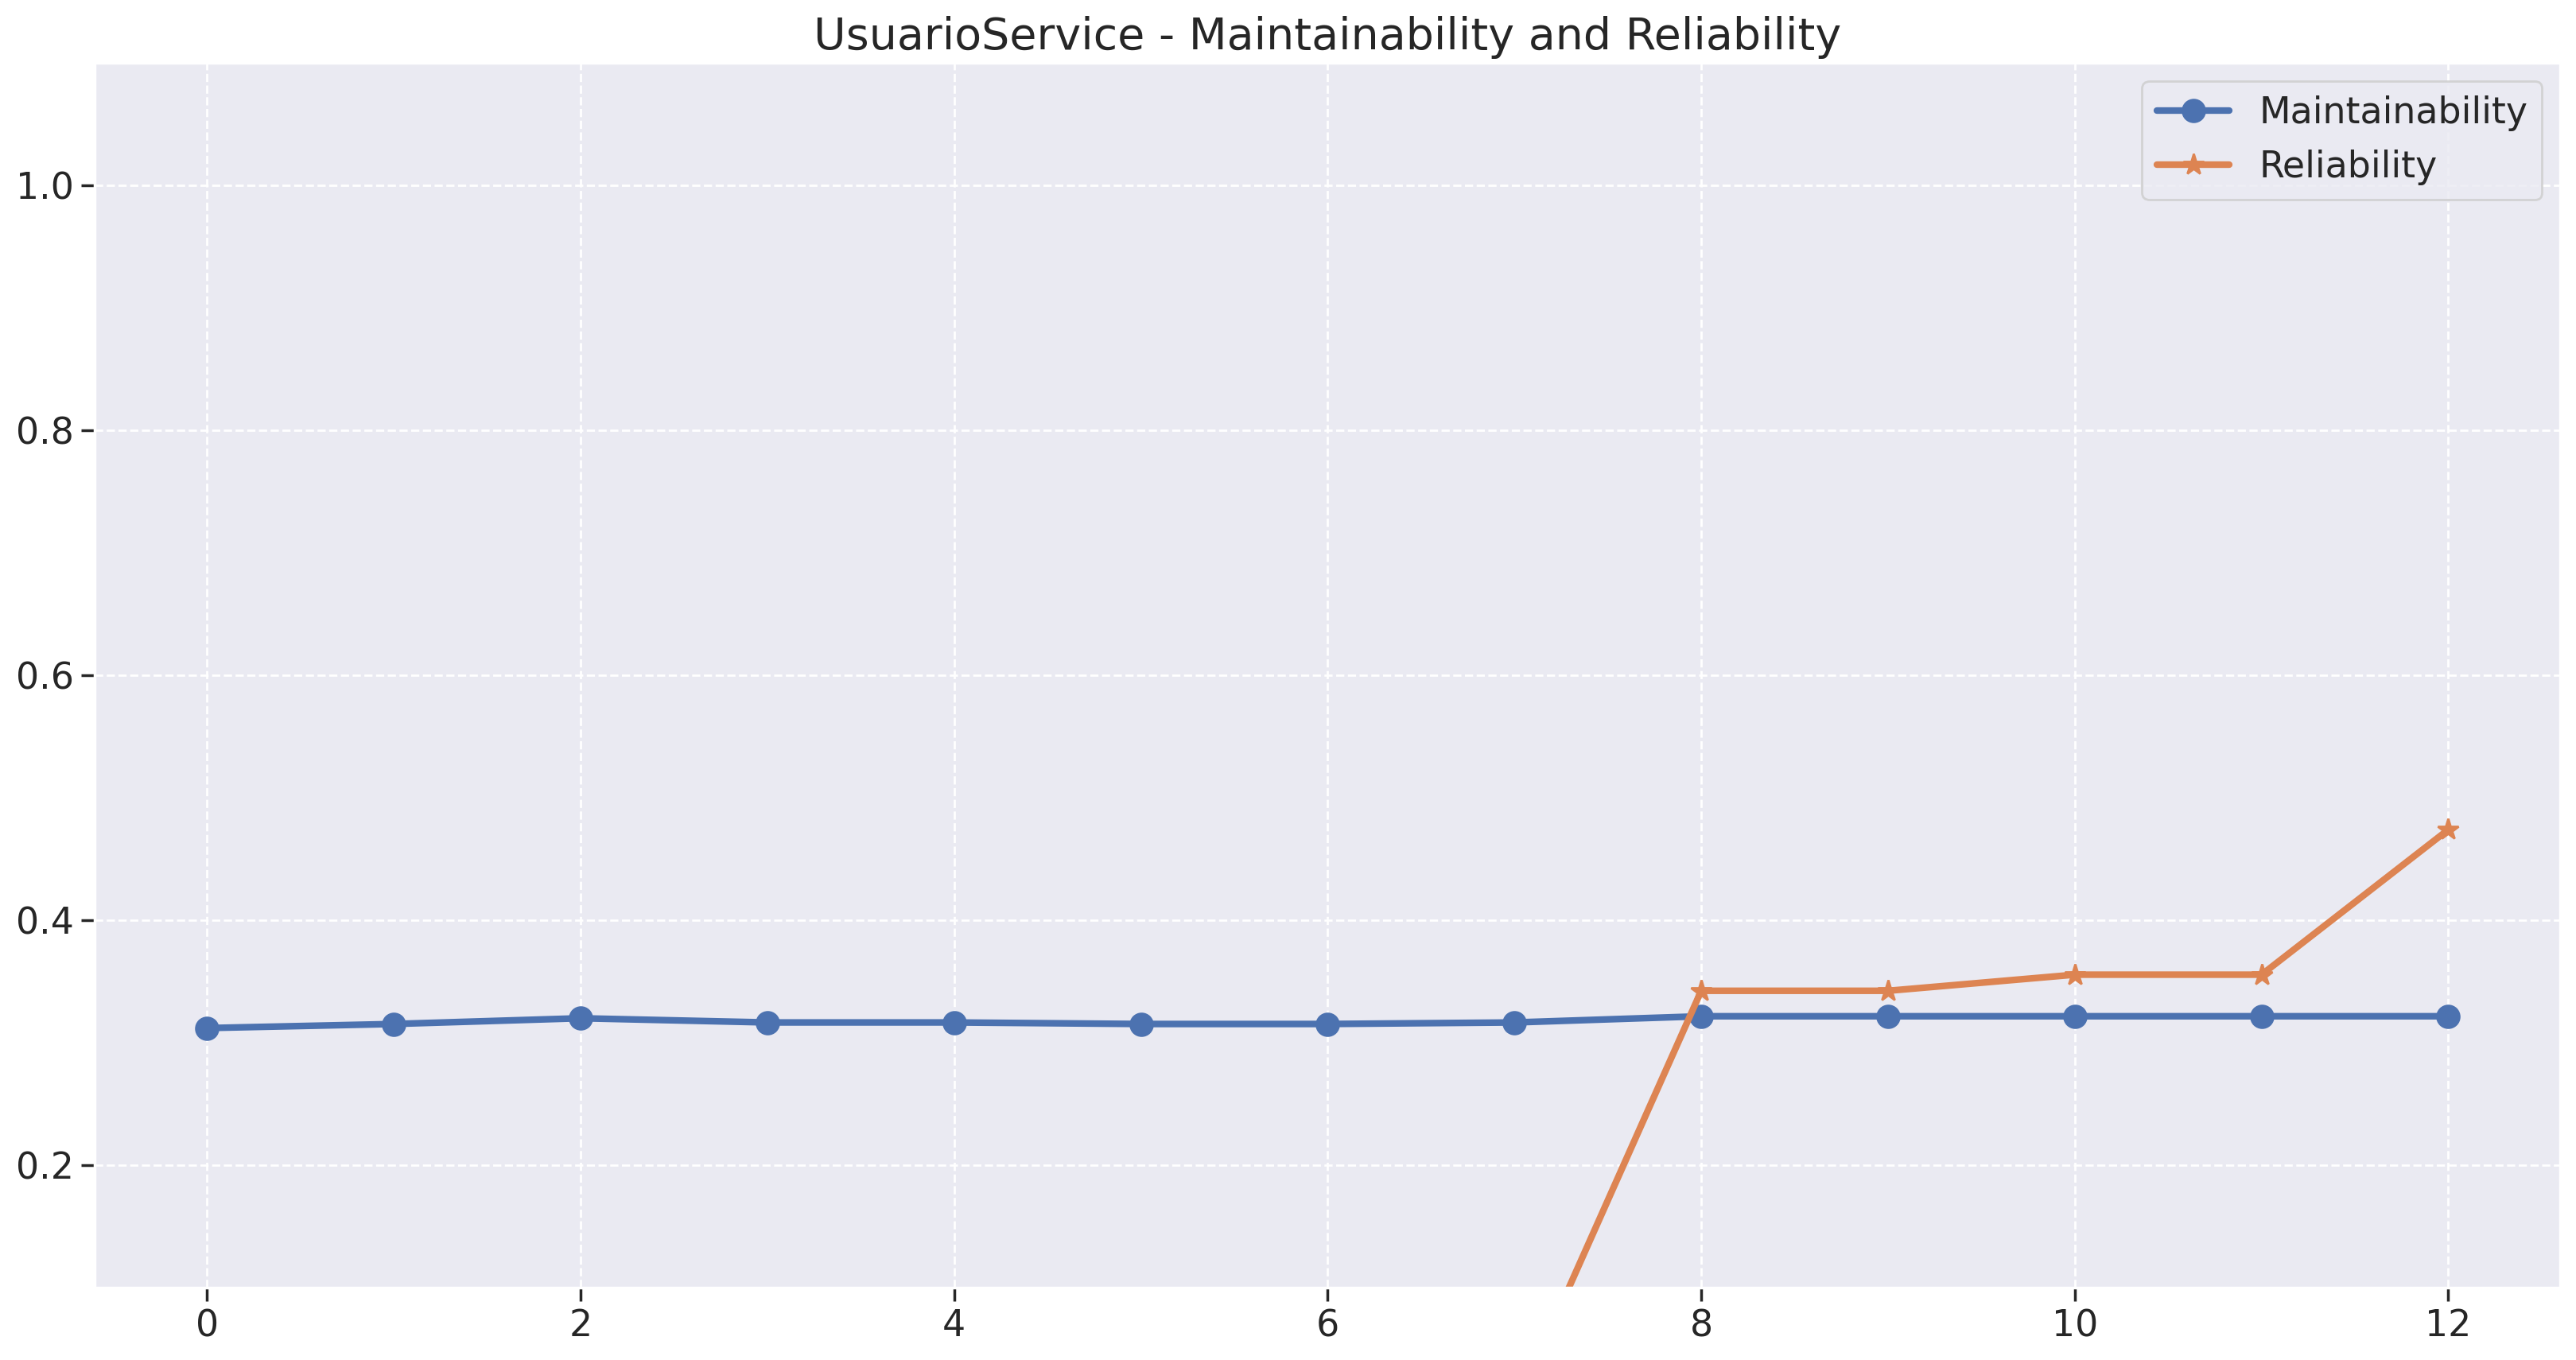

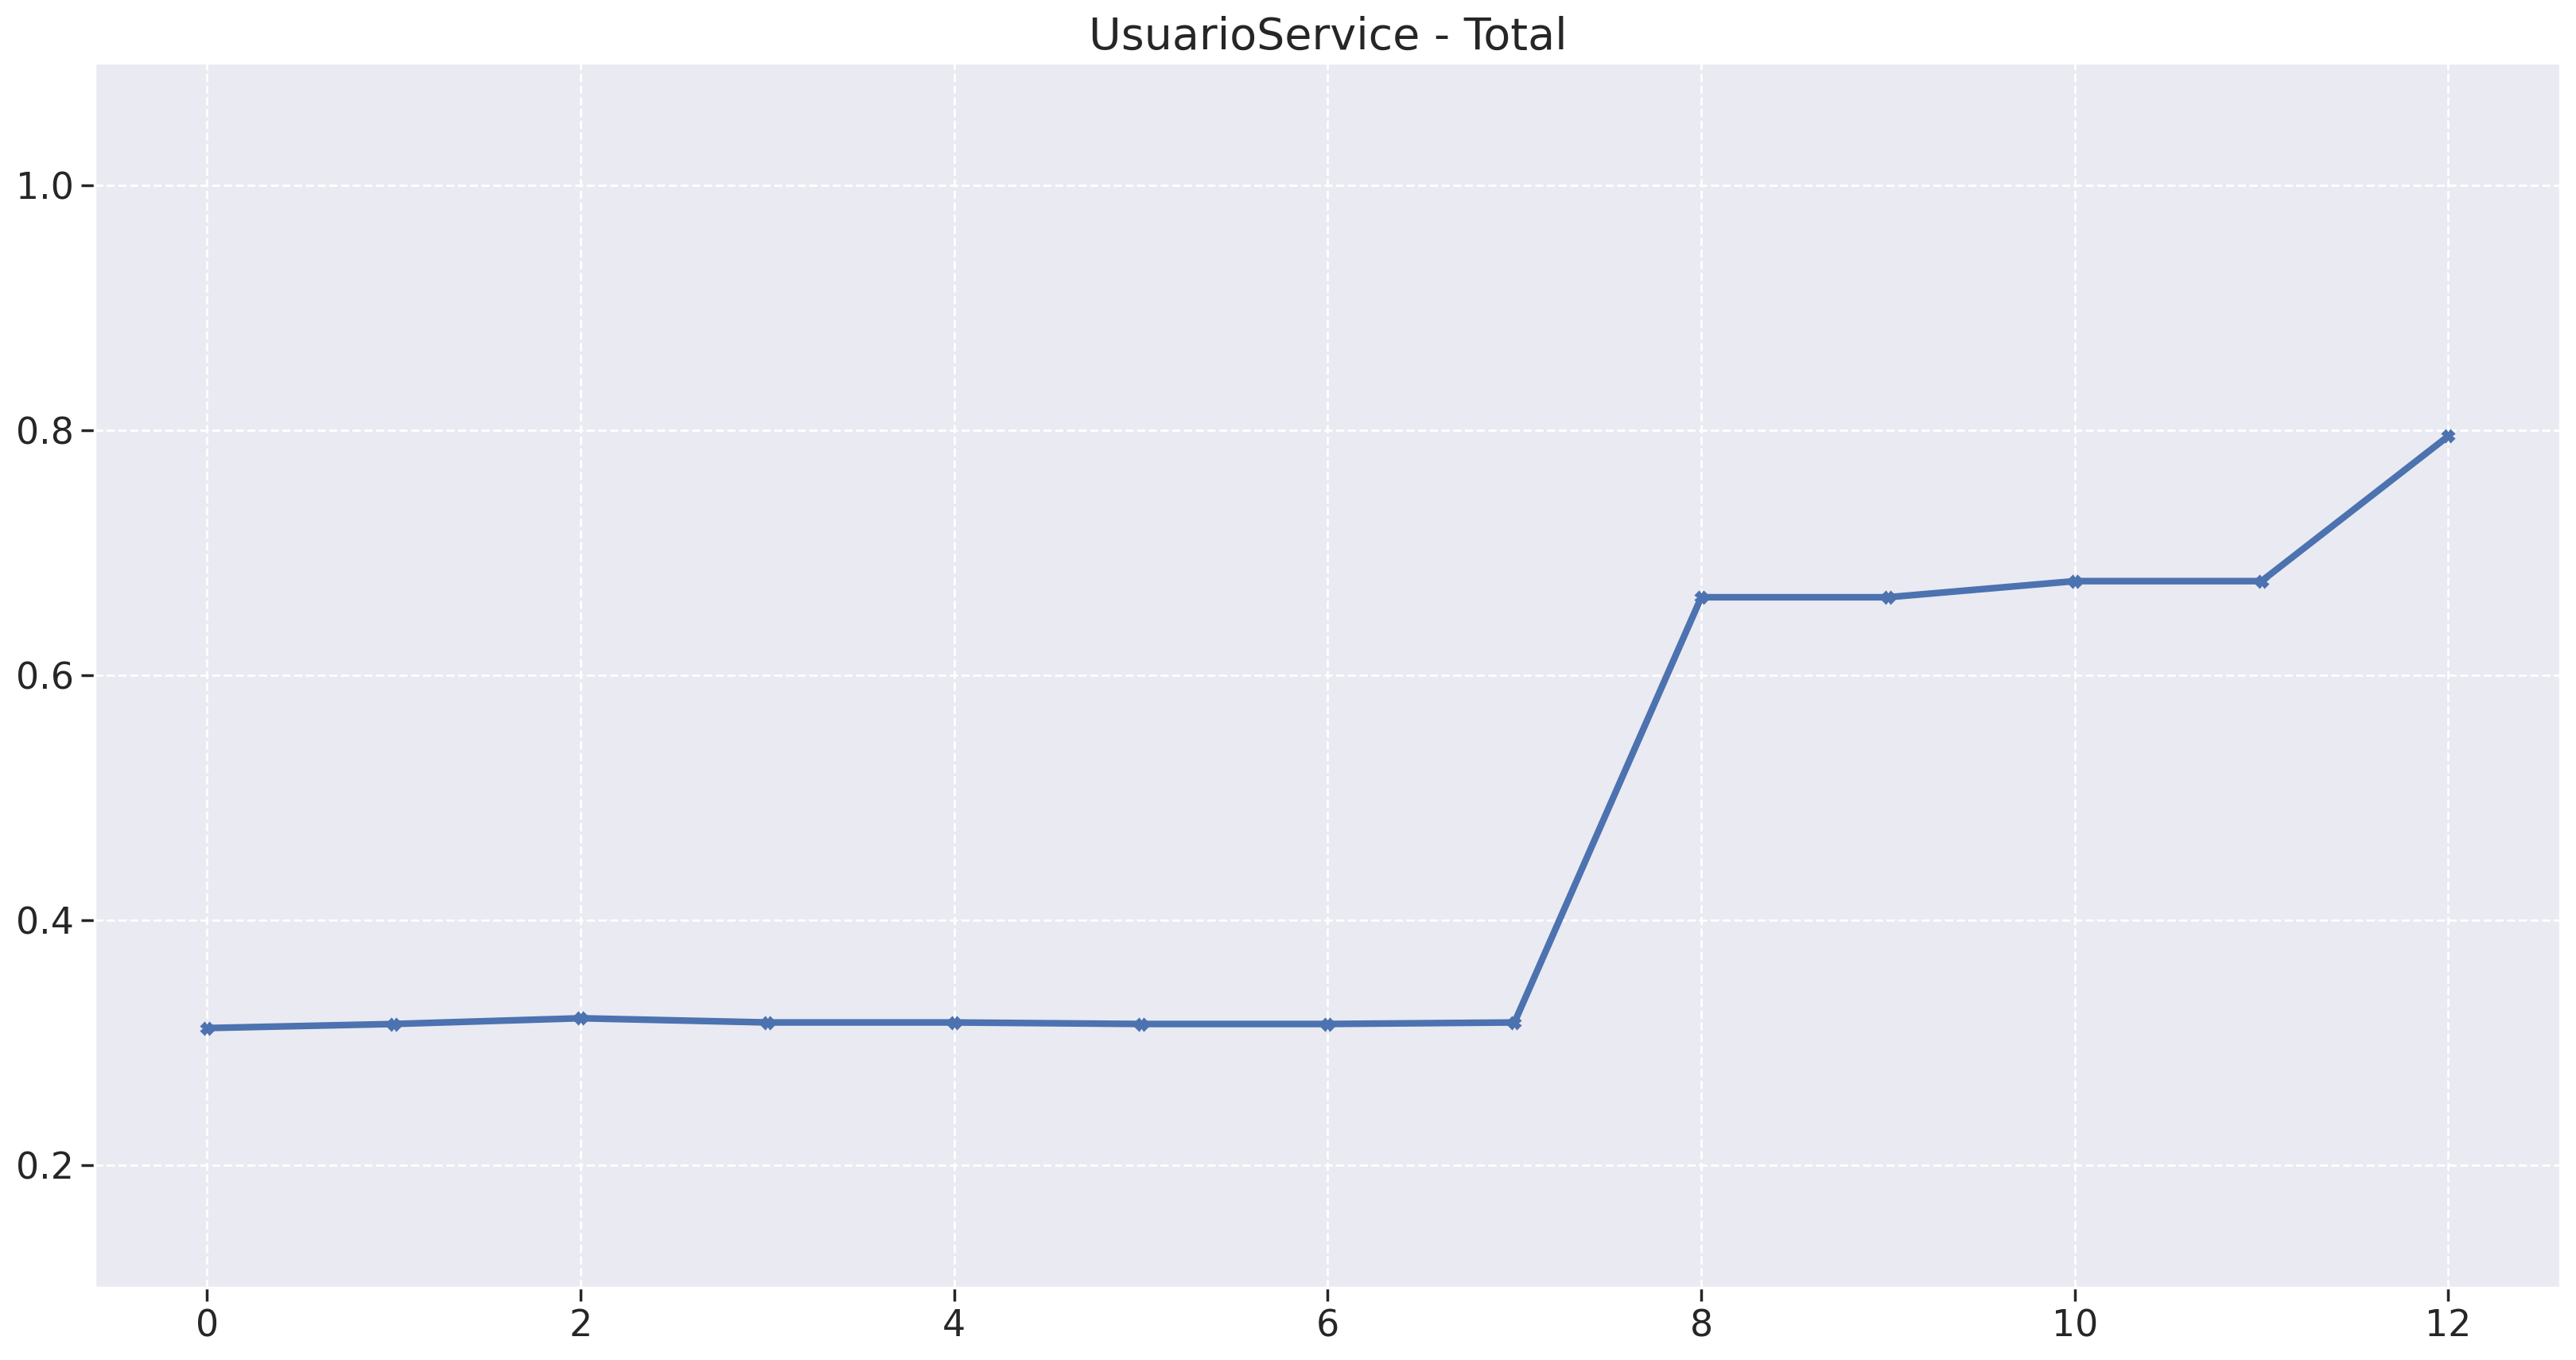

UpsService
Maintainability Stats
    mean     mode  median      std      var   min      max
0.318278 0.315000   0.319 0.002983 0.000009 0.315 0.320833
0.318278 0.319000   0.319 0.002983 0.000009 0.315 0.320833
0.318278 0.320833   0.319 0.002983 0.000009 0.315 0.320833
Reliability Stats
    mean     mode  median      std      var      min      max
0.292761 0.272727     0.3 0.017571 0.000309 0.272727 0.305556
0.292761 0.300000     0.3 0.017571 0.000309 0.272727 0.305556
0.292761 0.305556     0.3 0.017571 0.000309 0.272727 0.305556


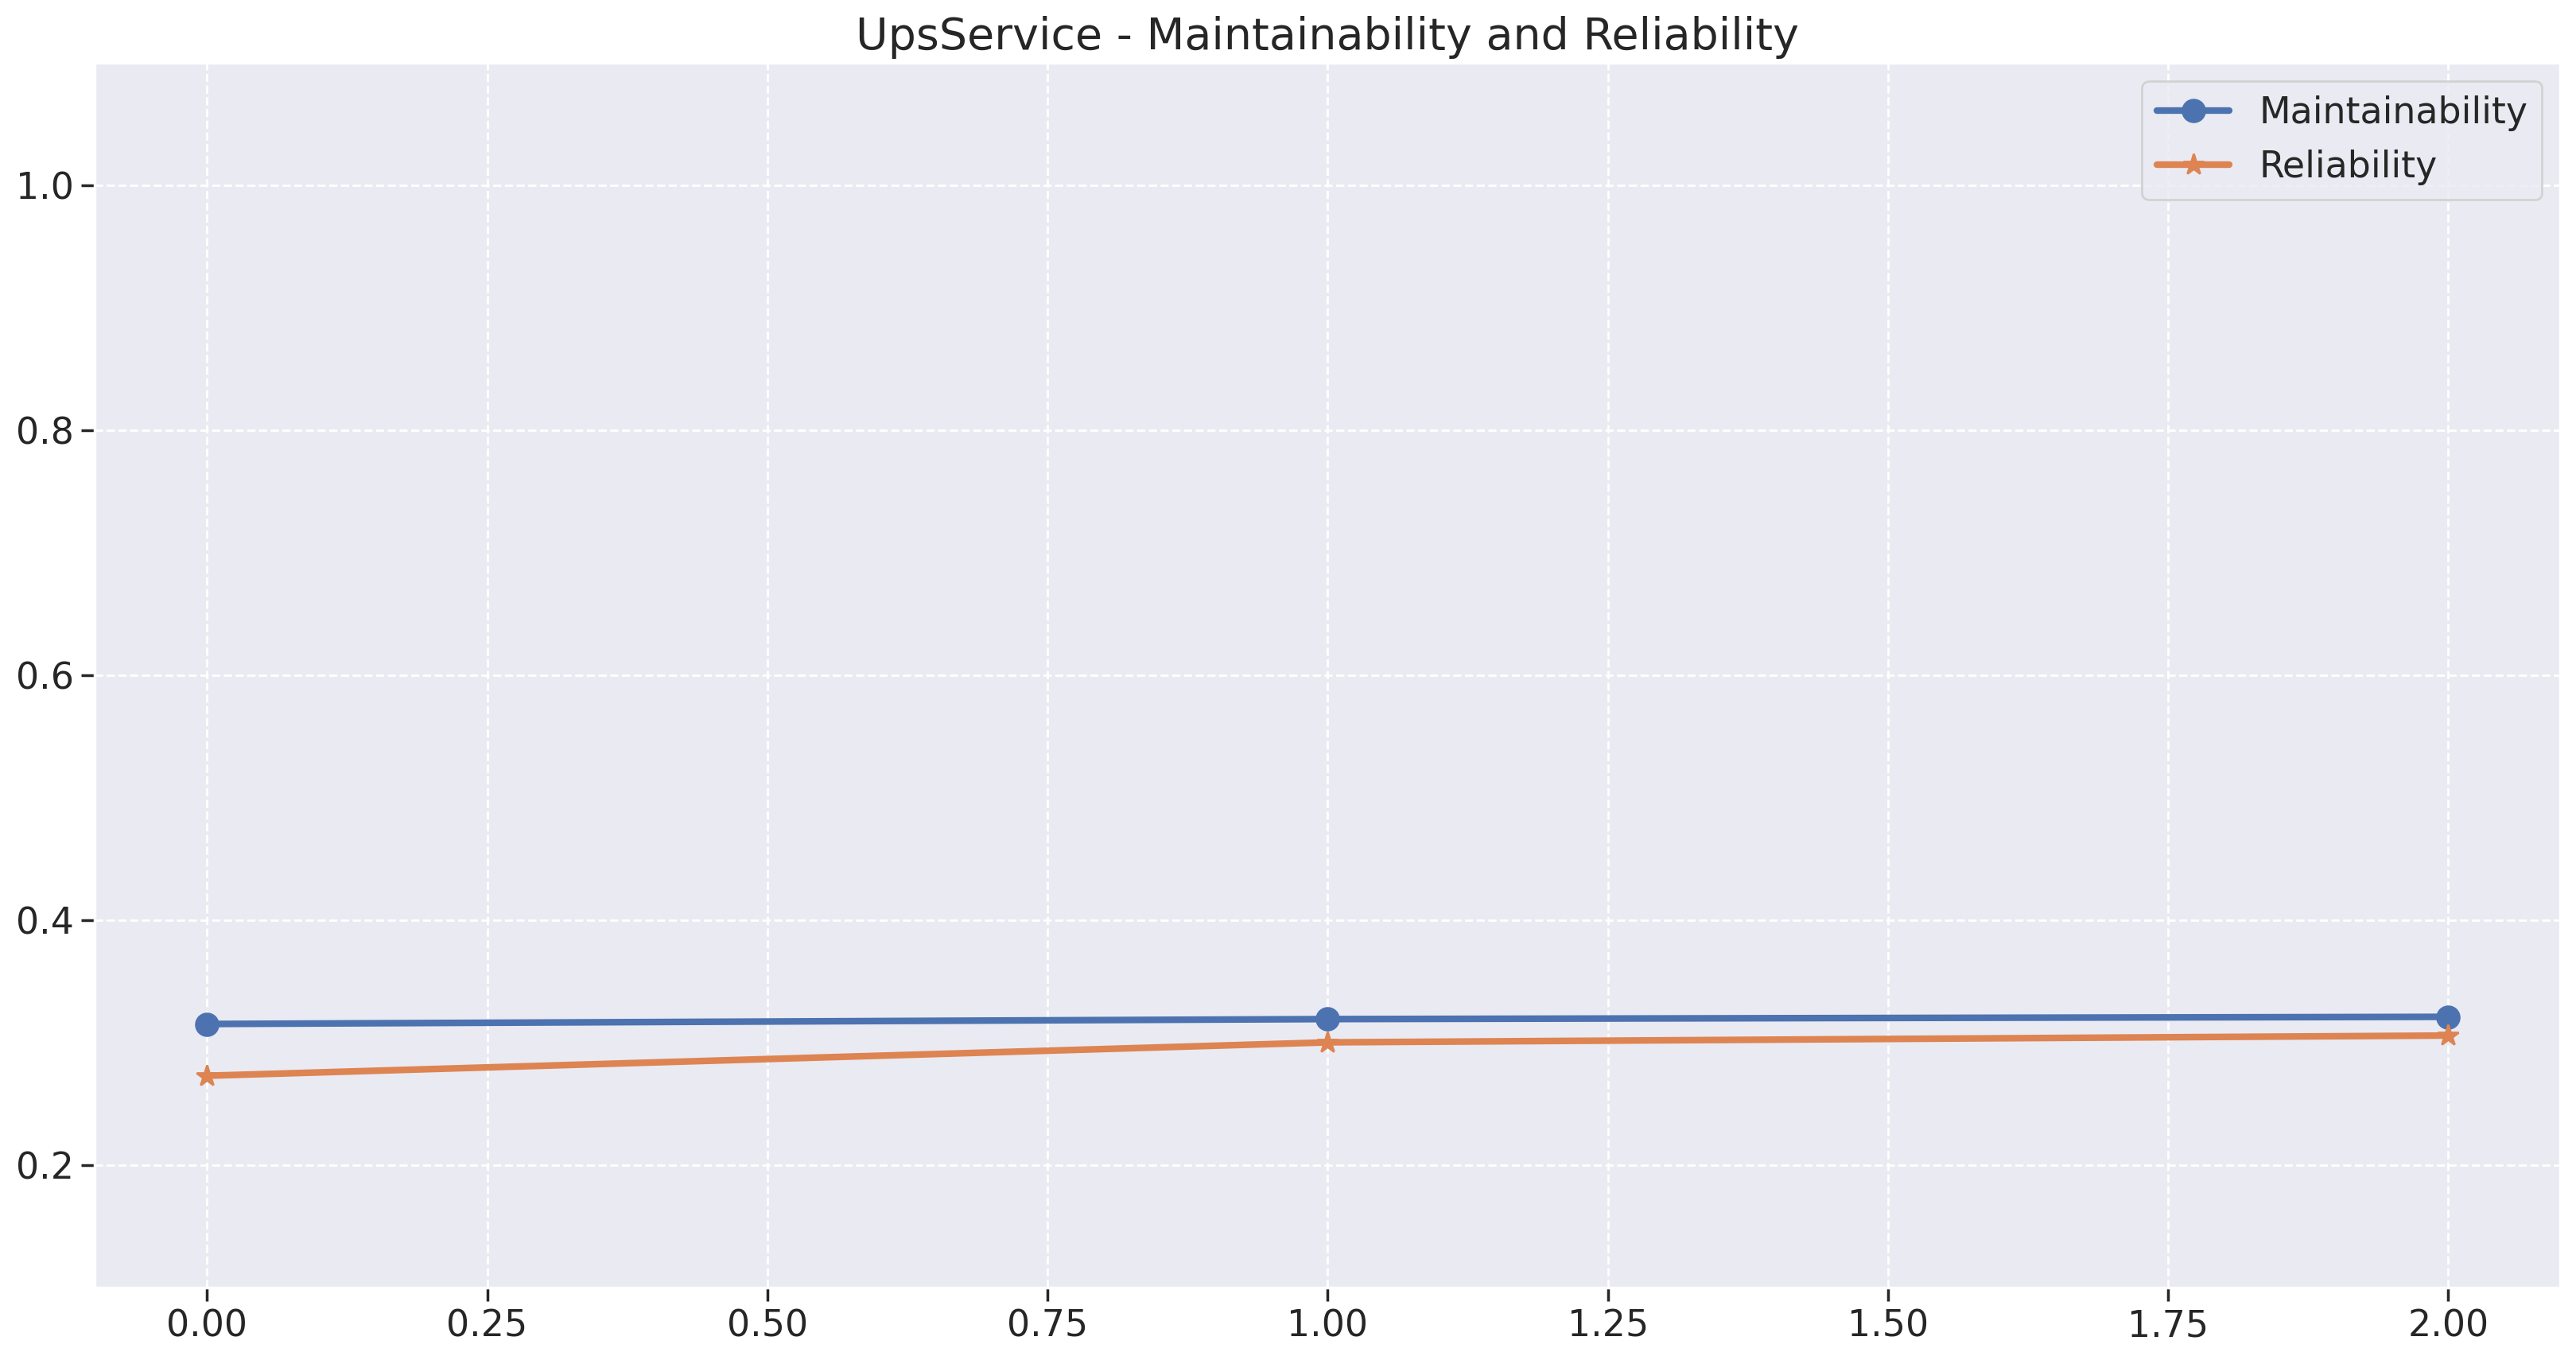

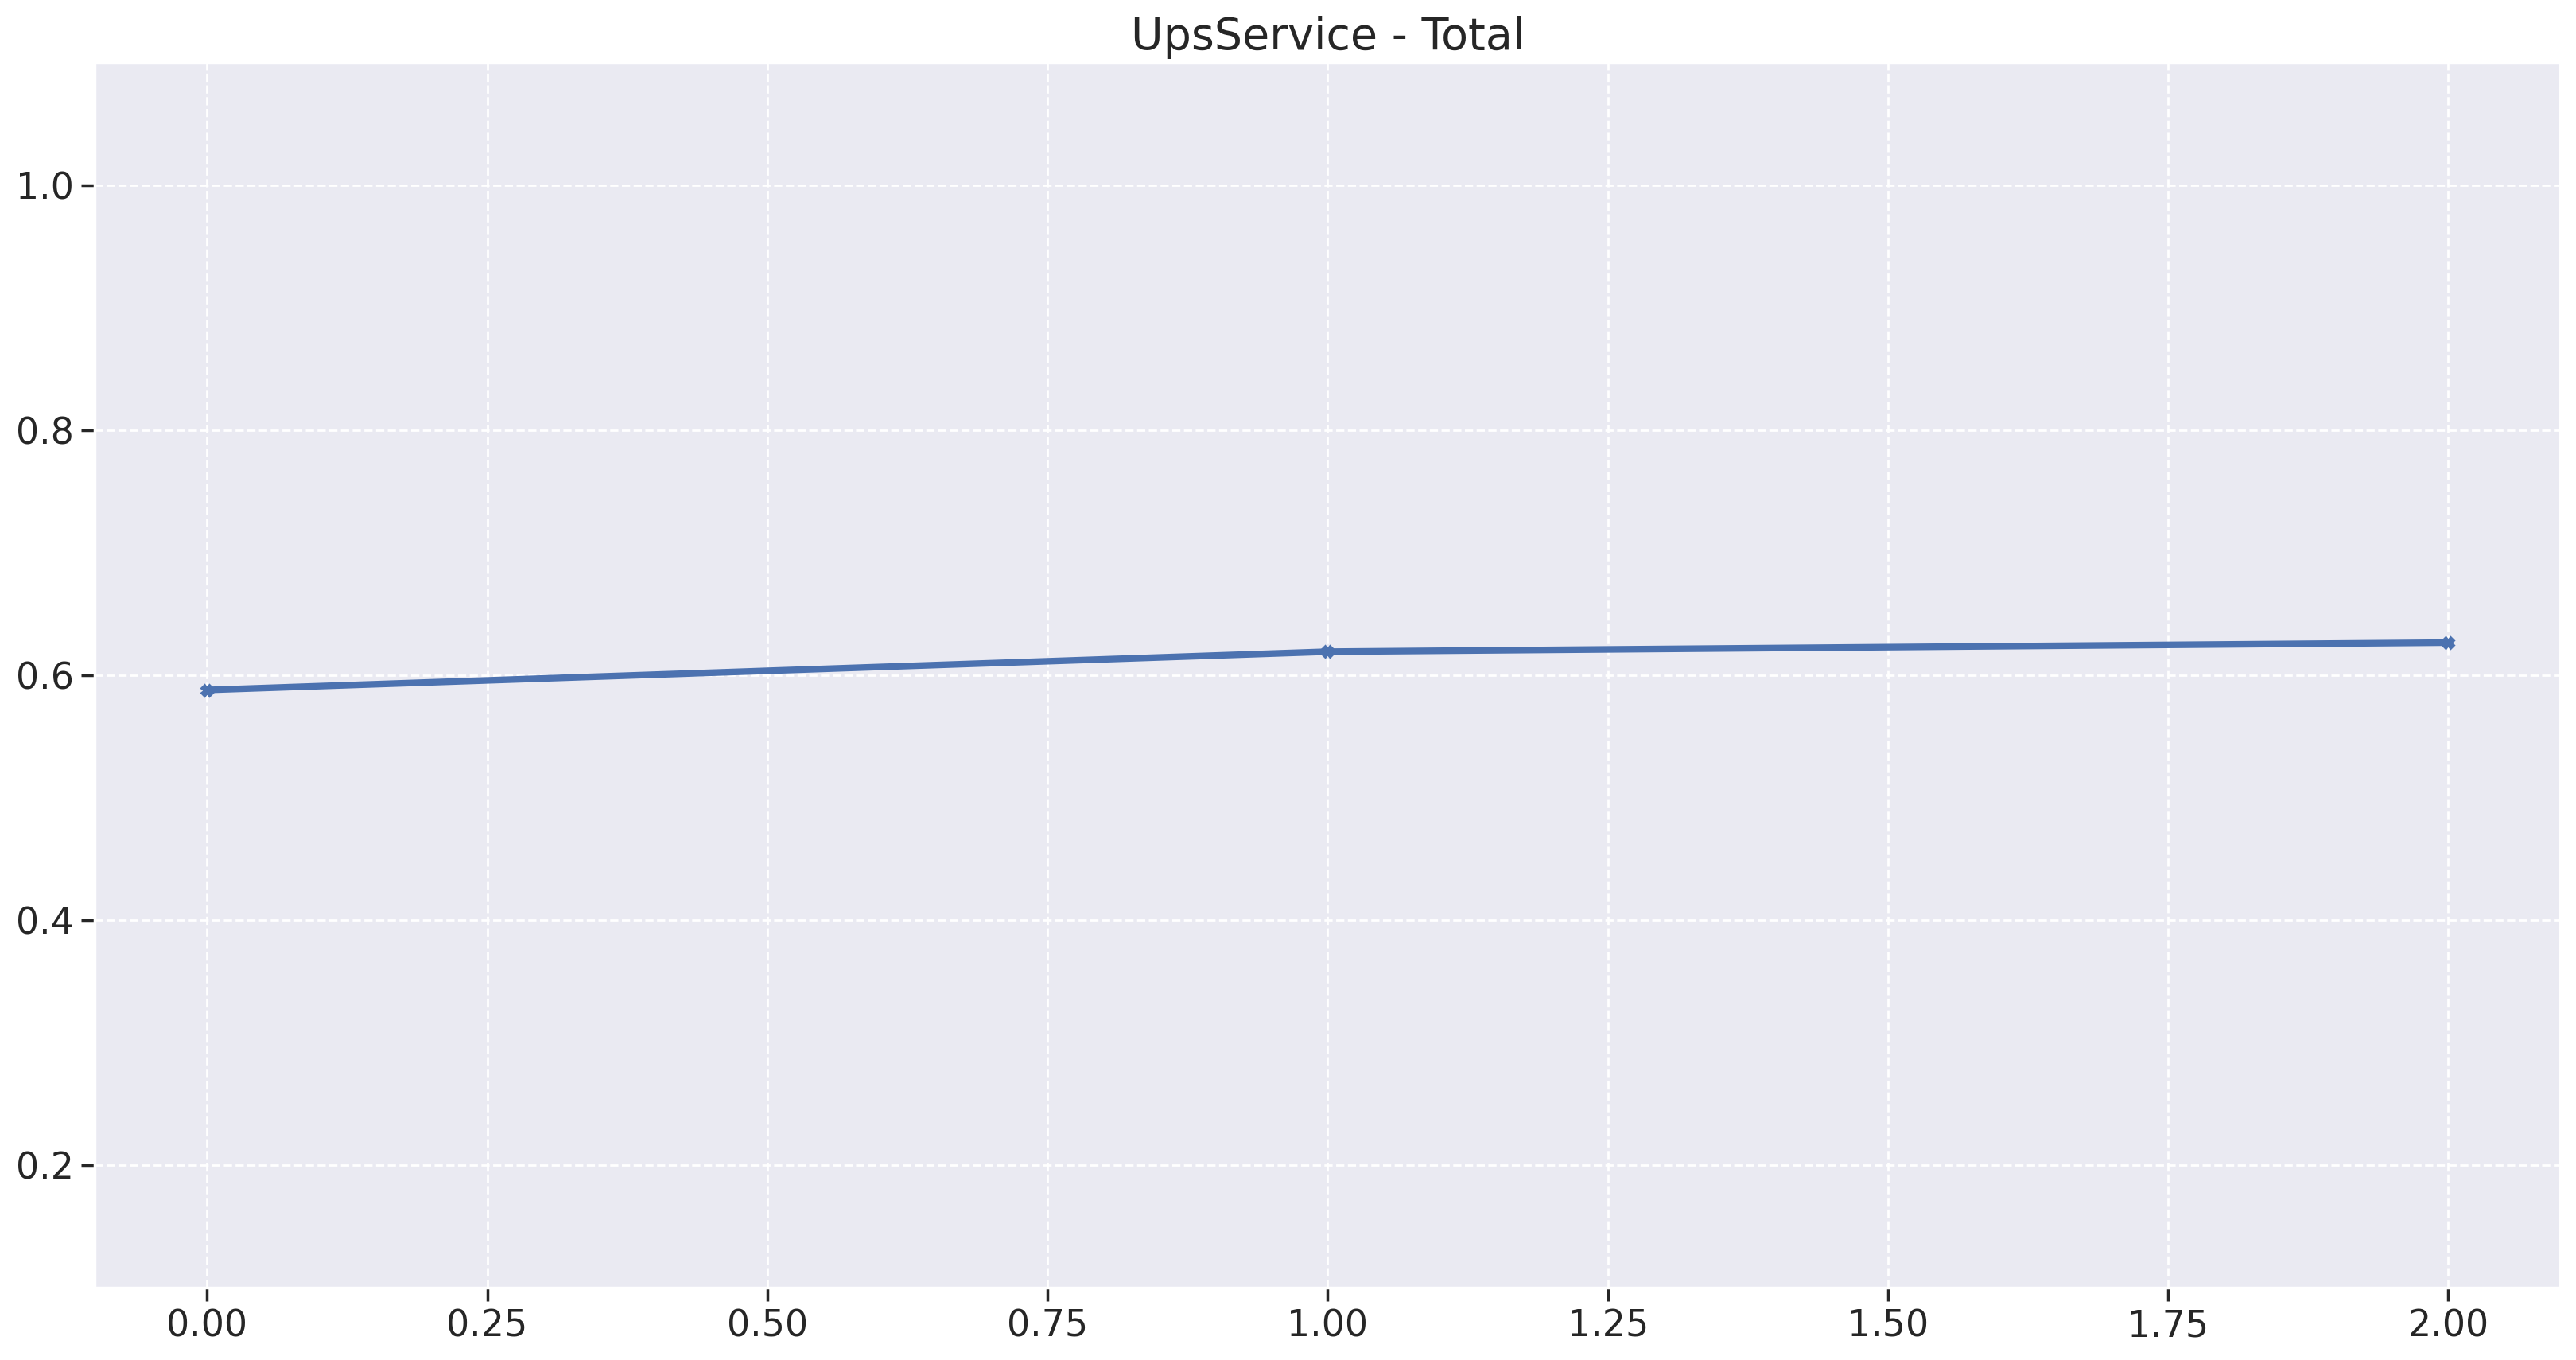

Front
Maintainability Stats
    mean     mode   median      std      var    min  max
0.320664 0.323889 0.323889 0.009608 0.000092 0.2805 0.33
Reliability Stats
    mean     mode   median      std      var  min      max
0.359684 0.412037 0.412037 0.121927 0.014866  0.0 0.419492


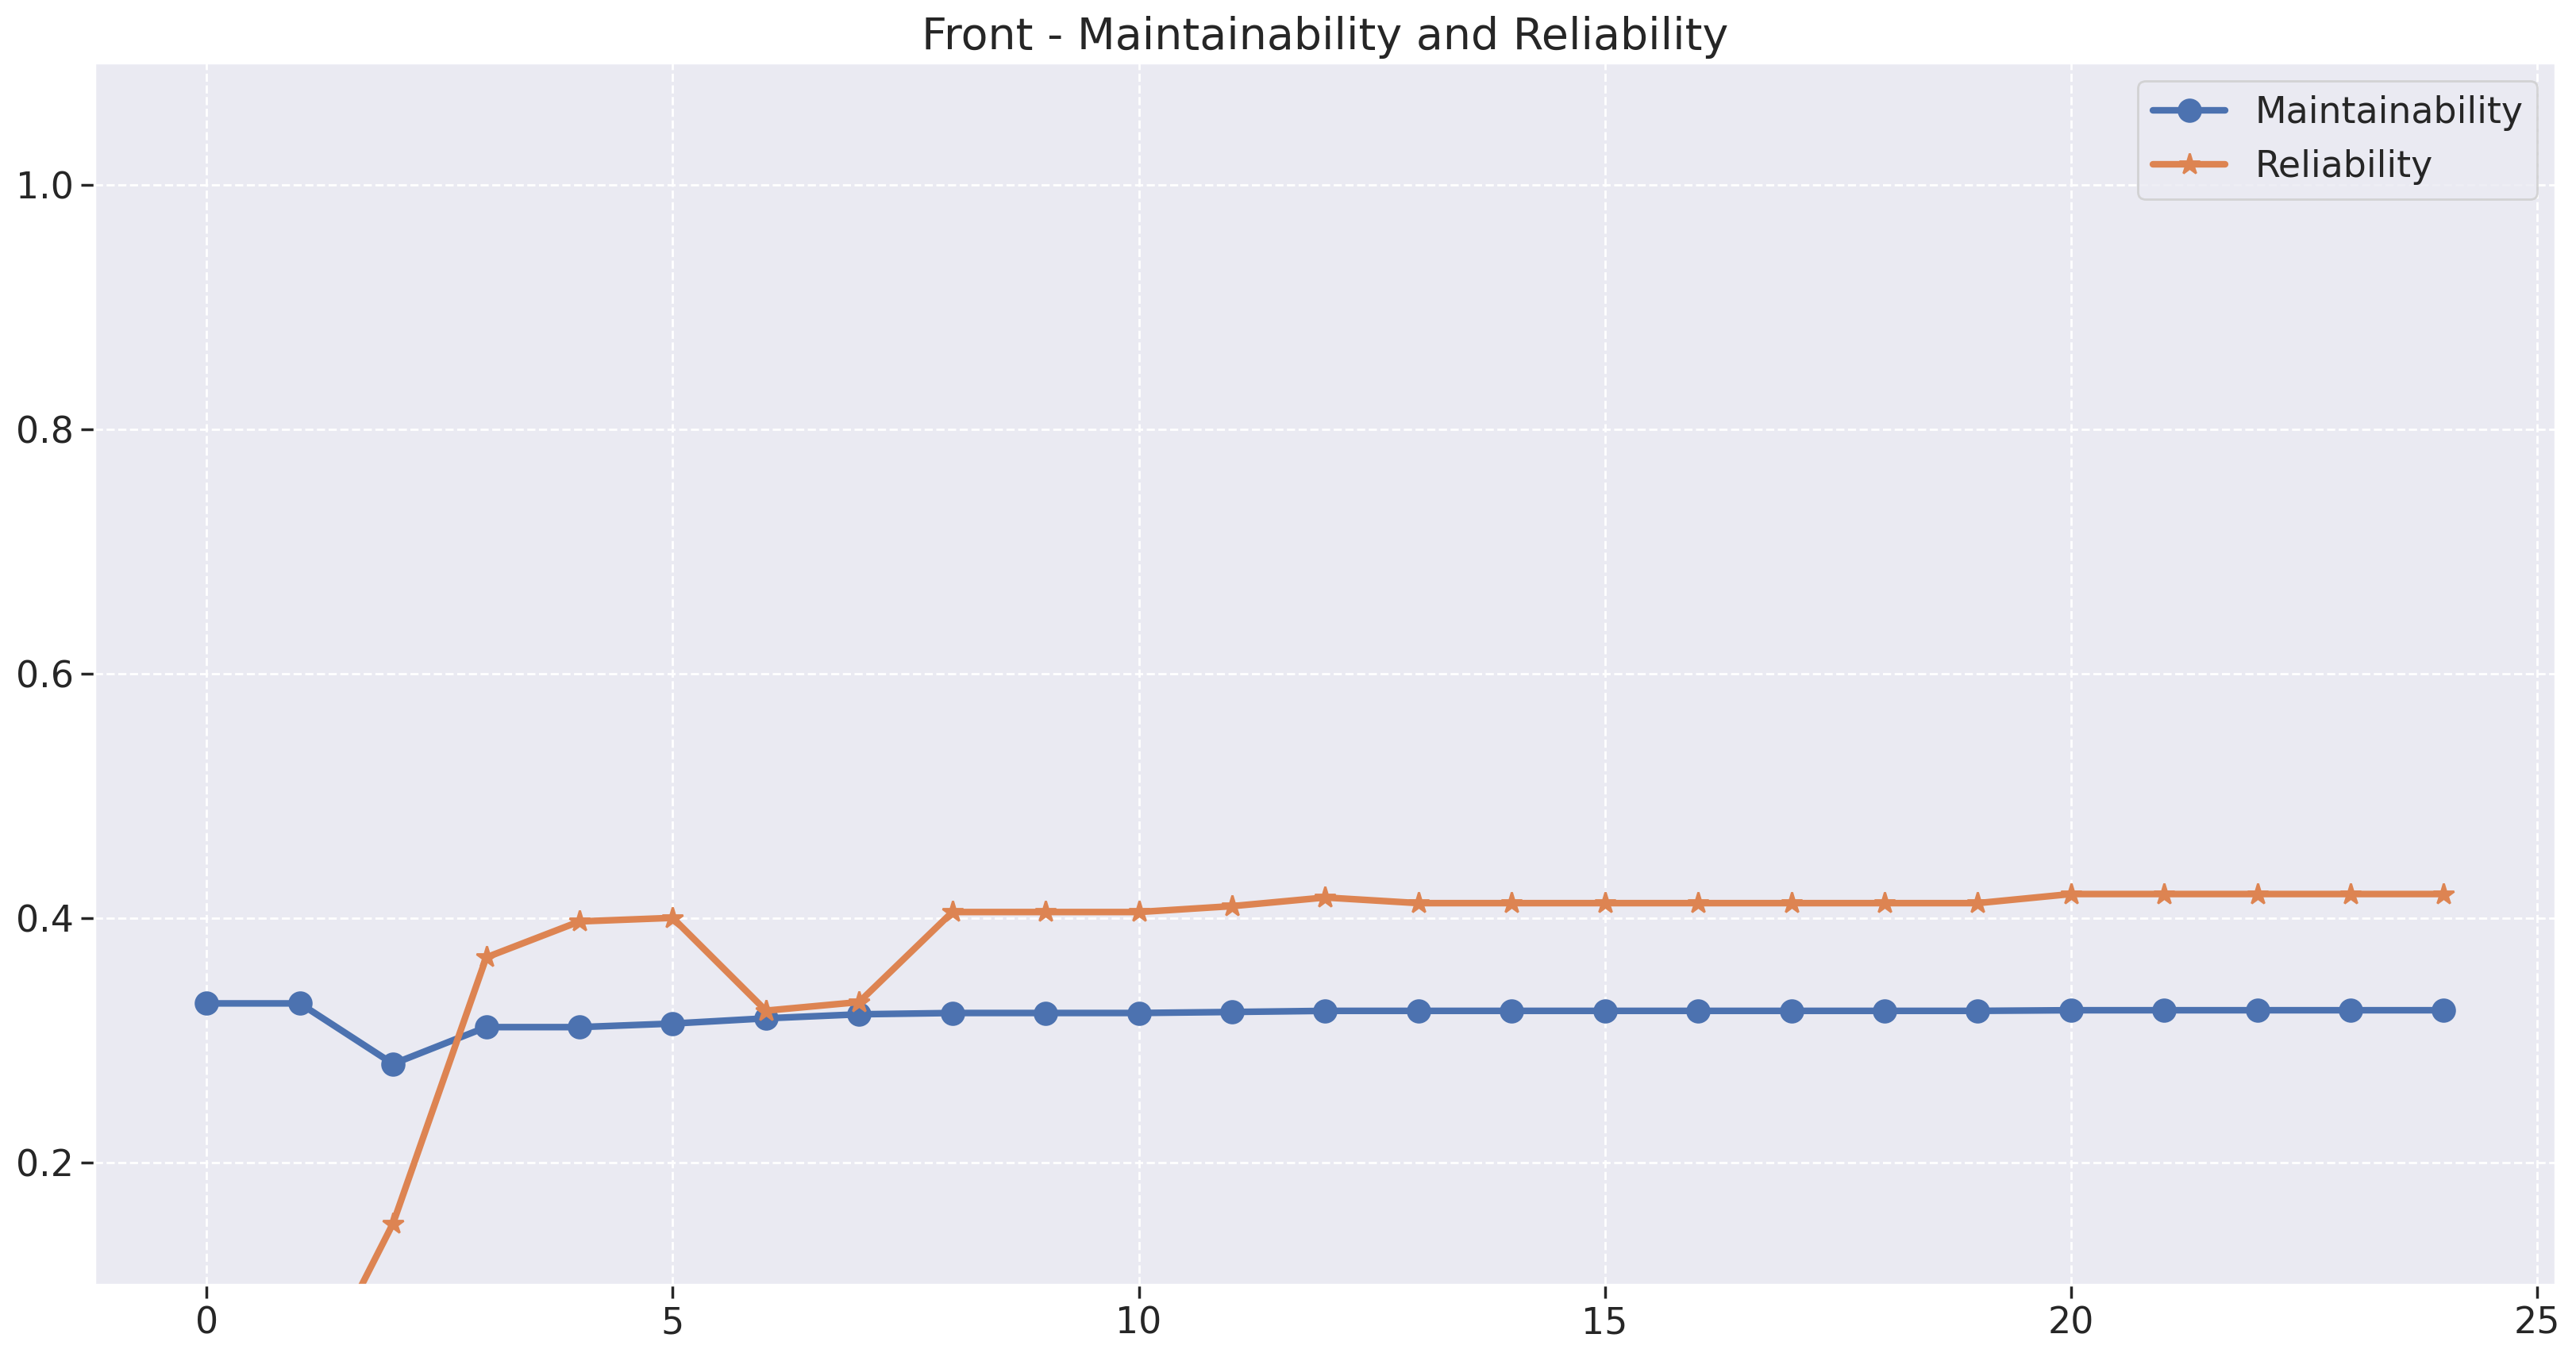

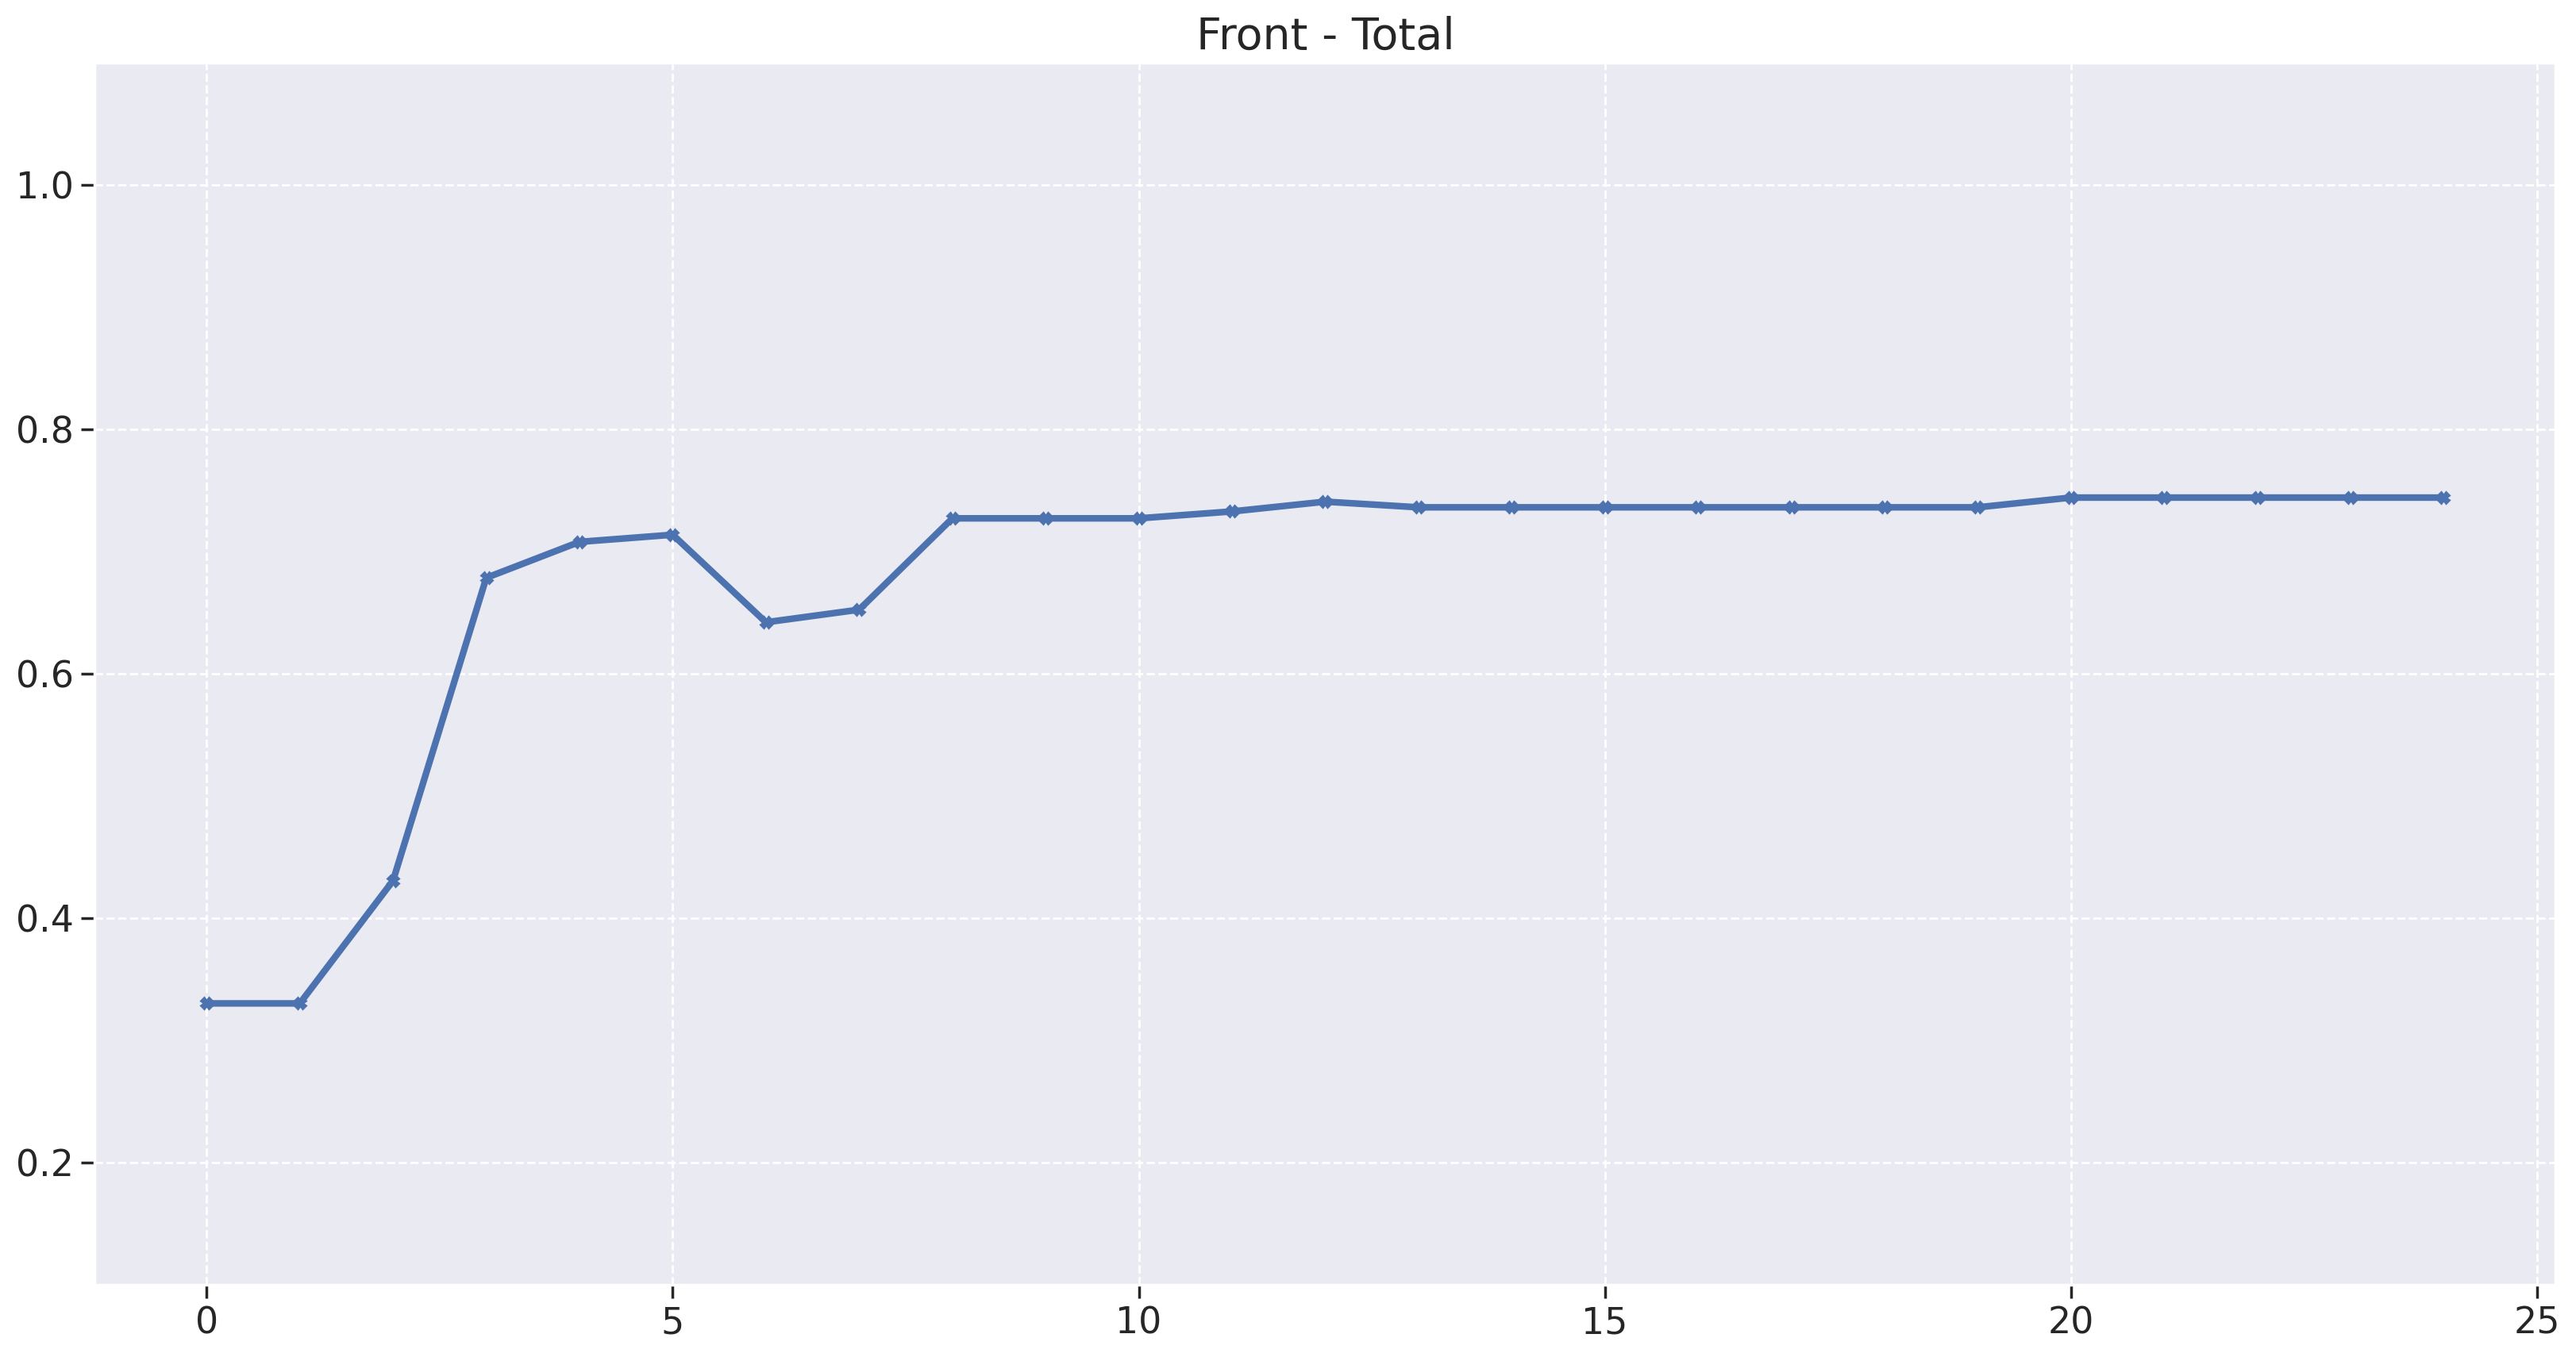

In [309]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

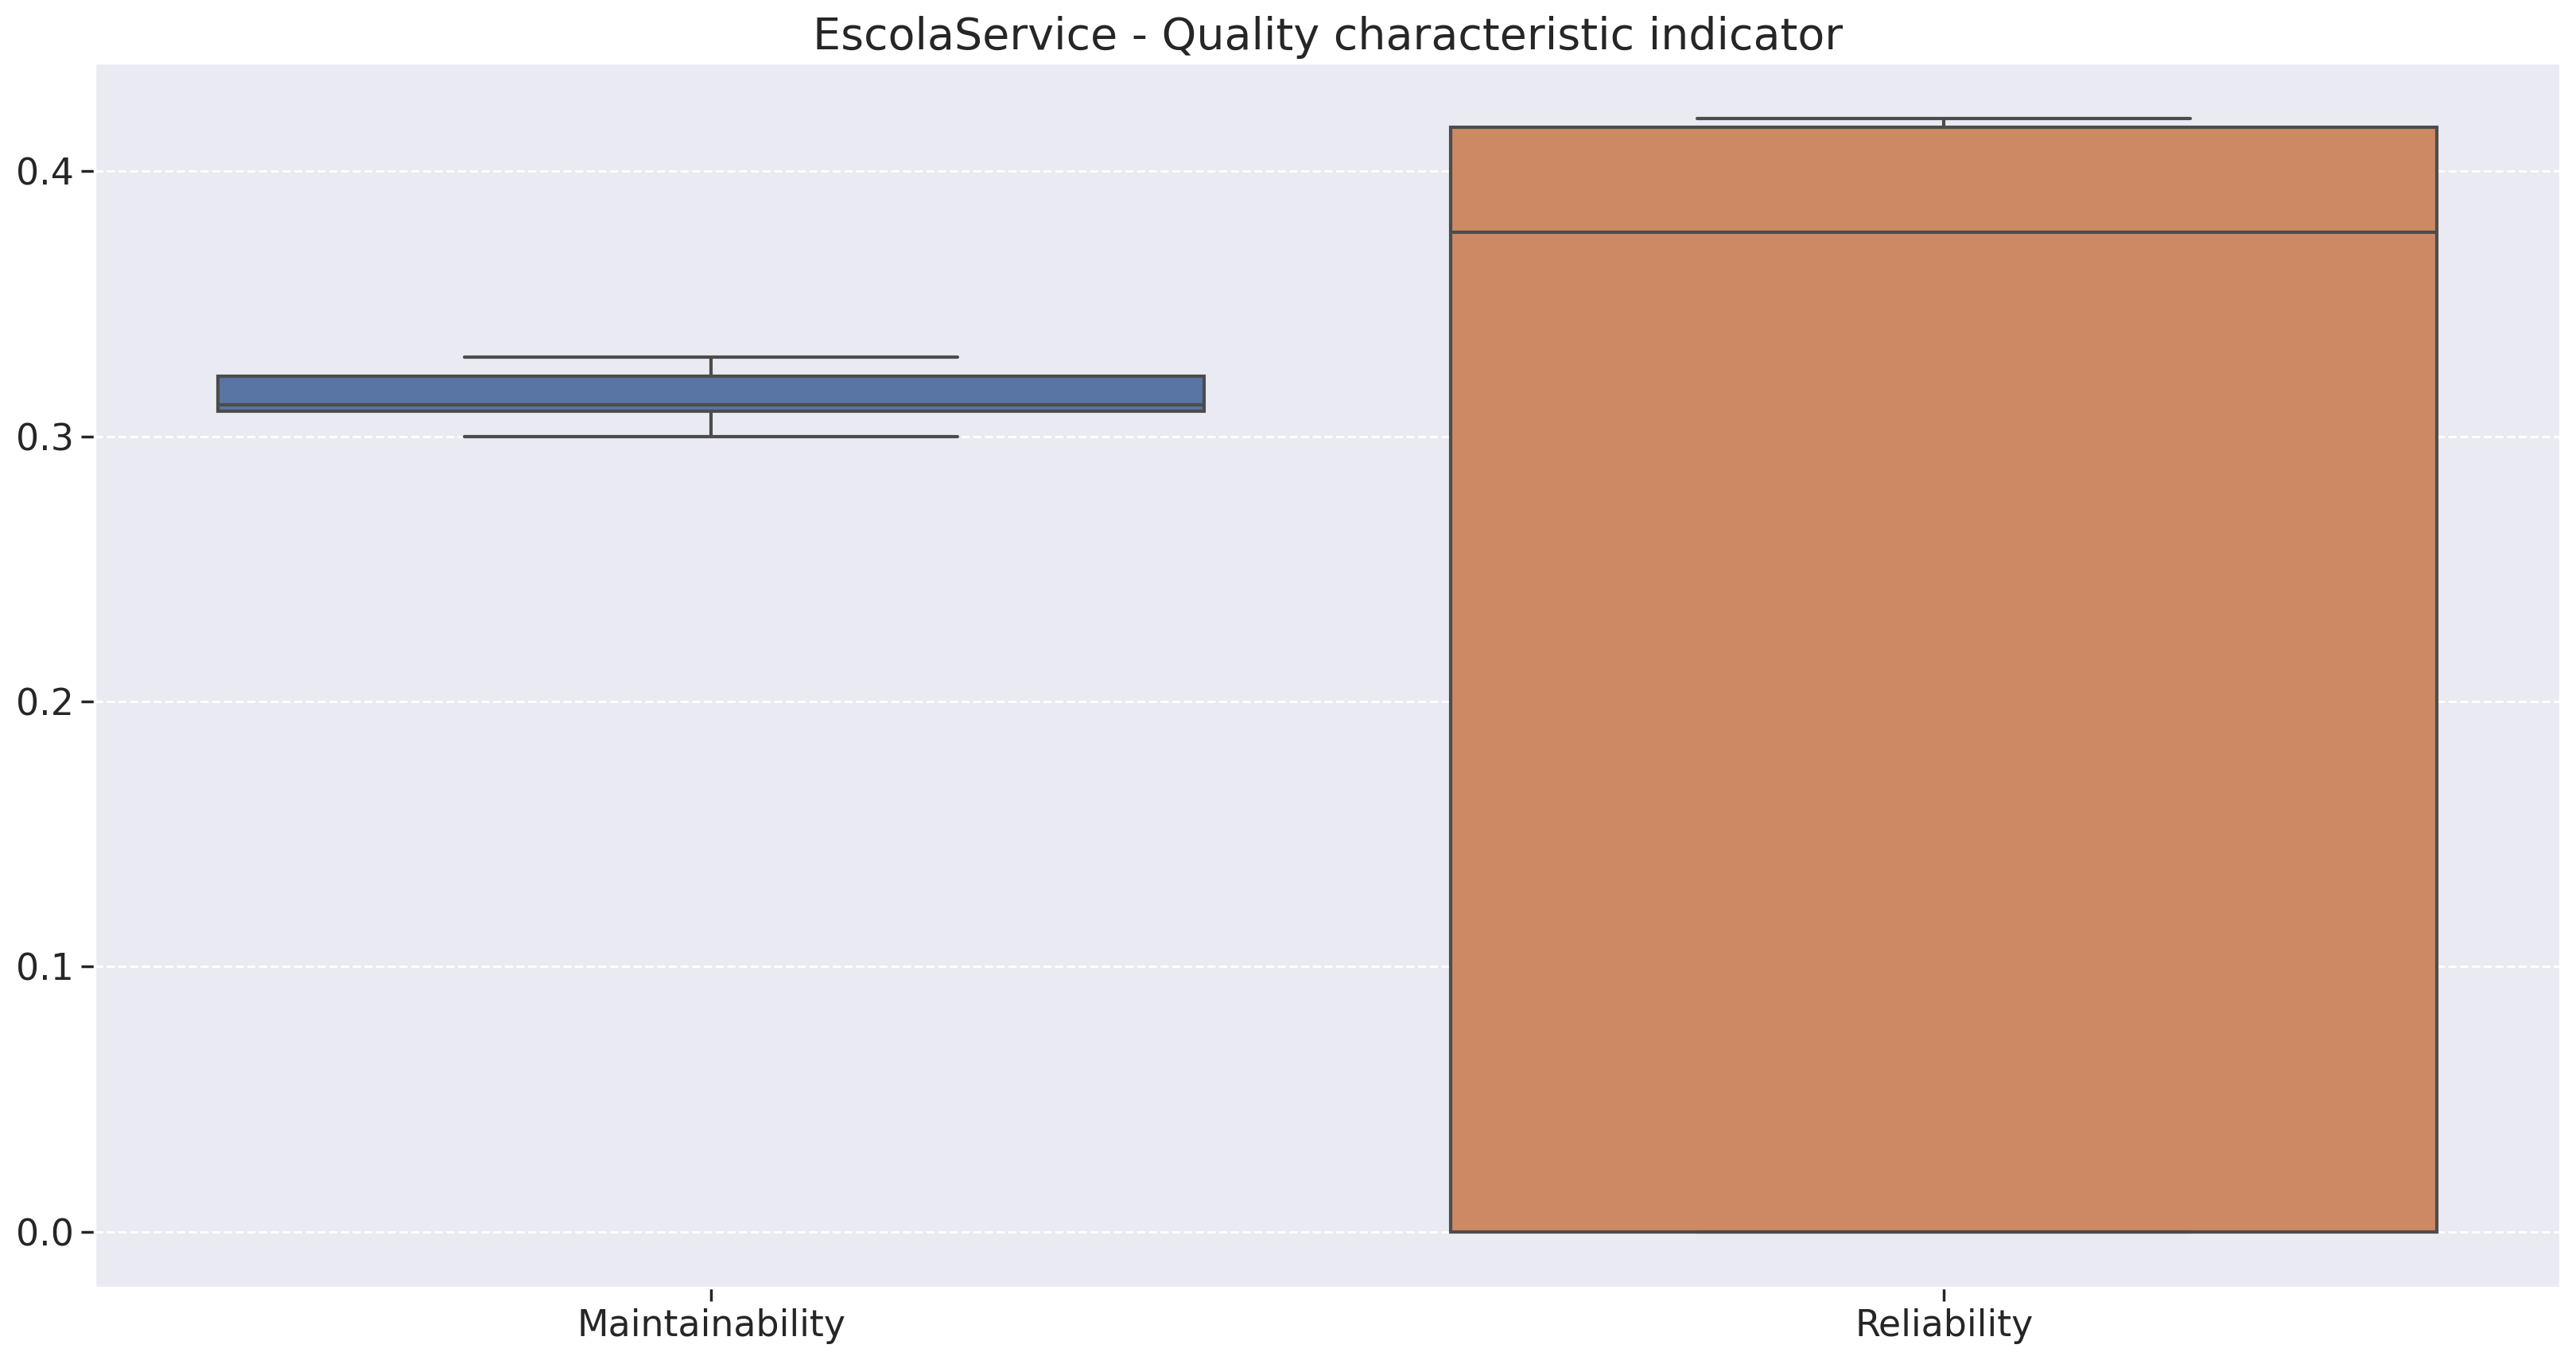

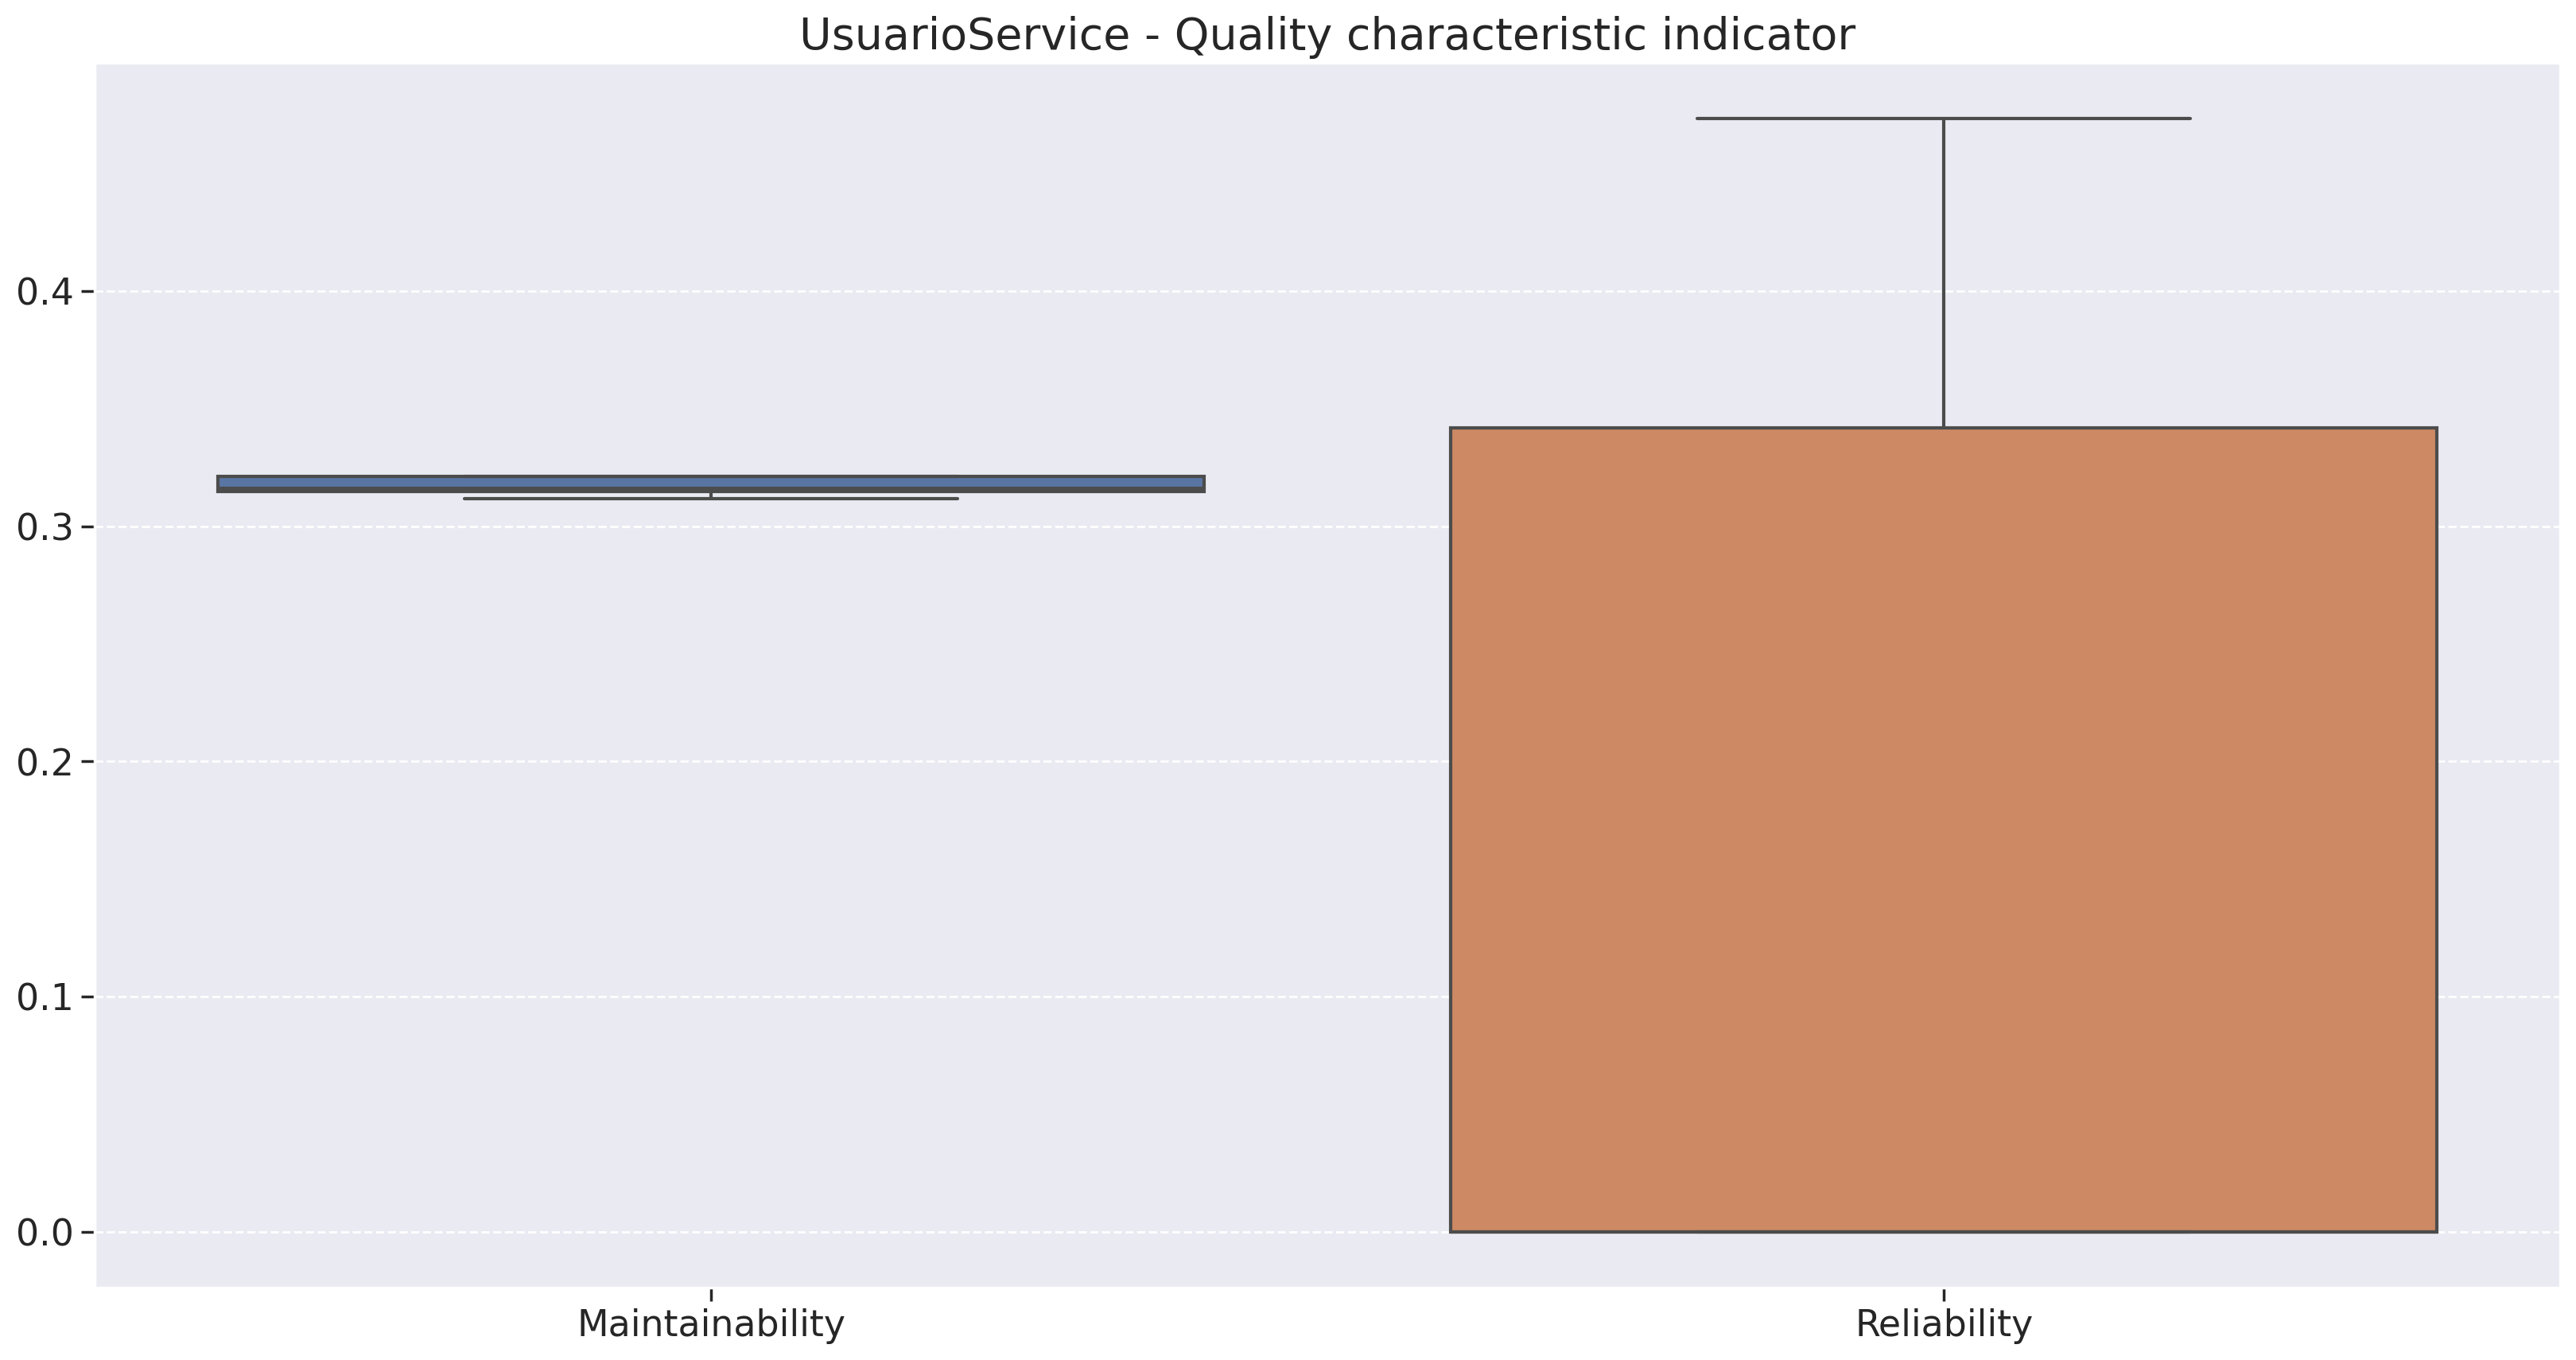

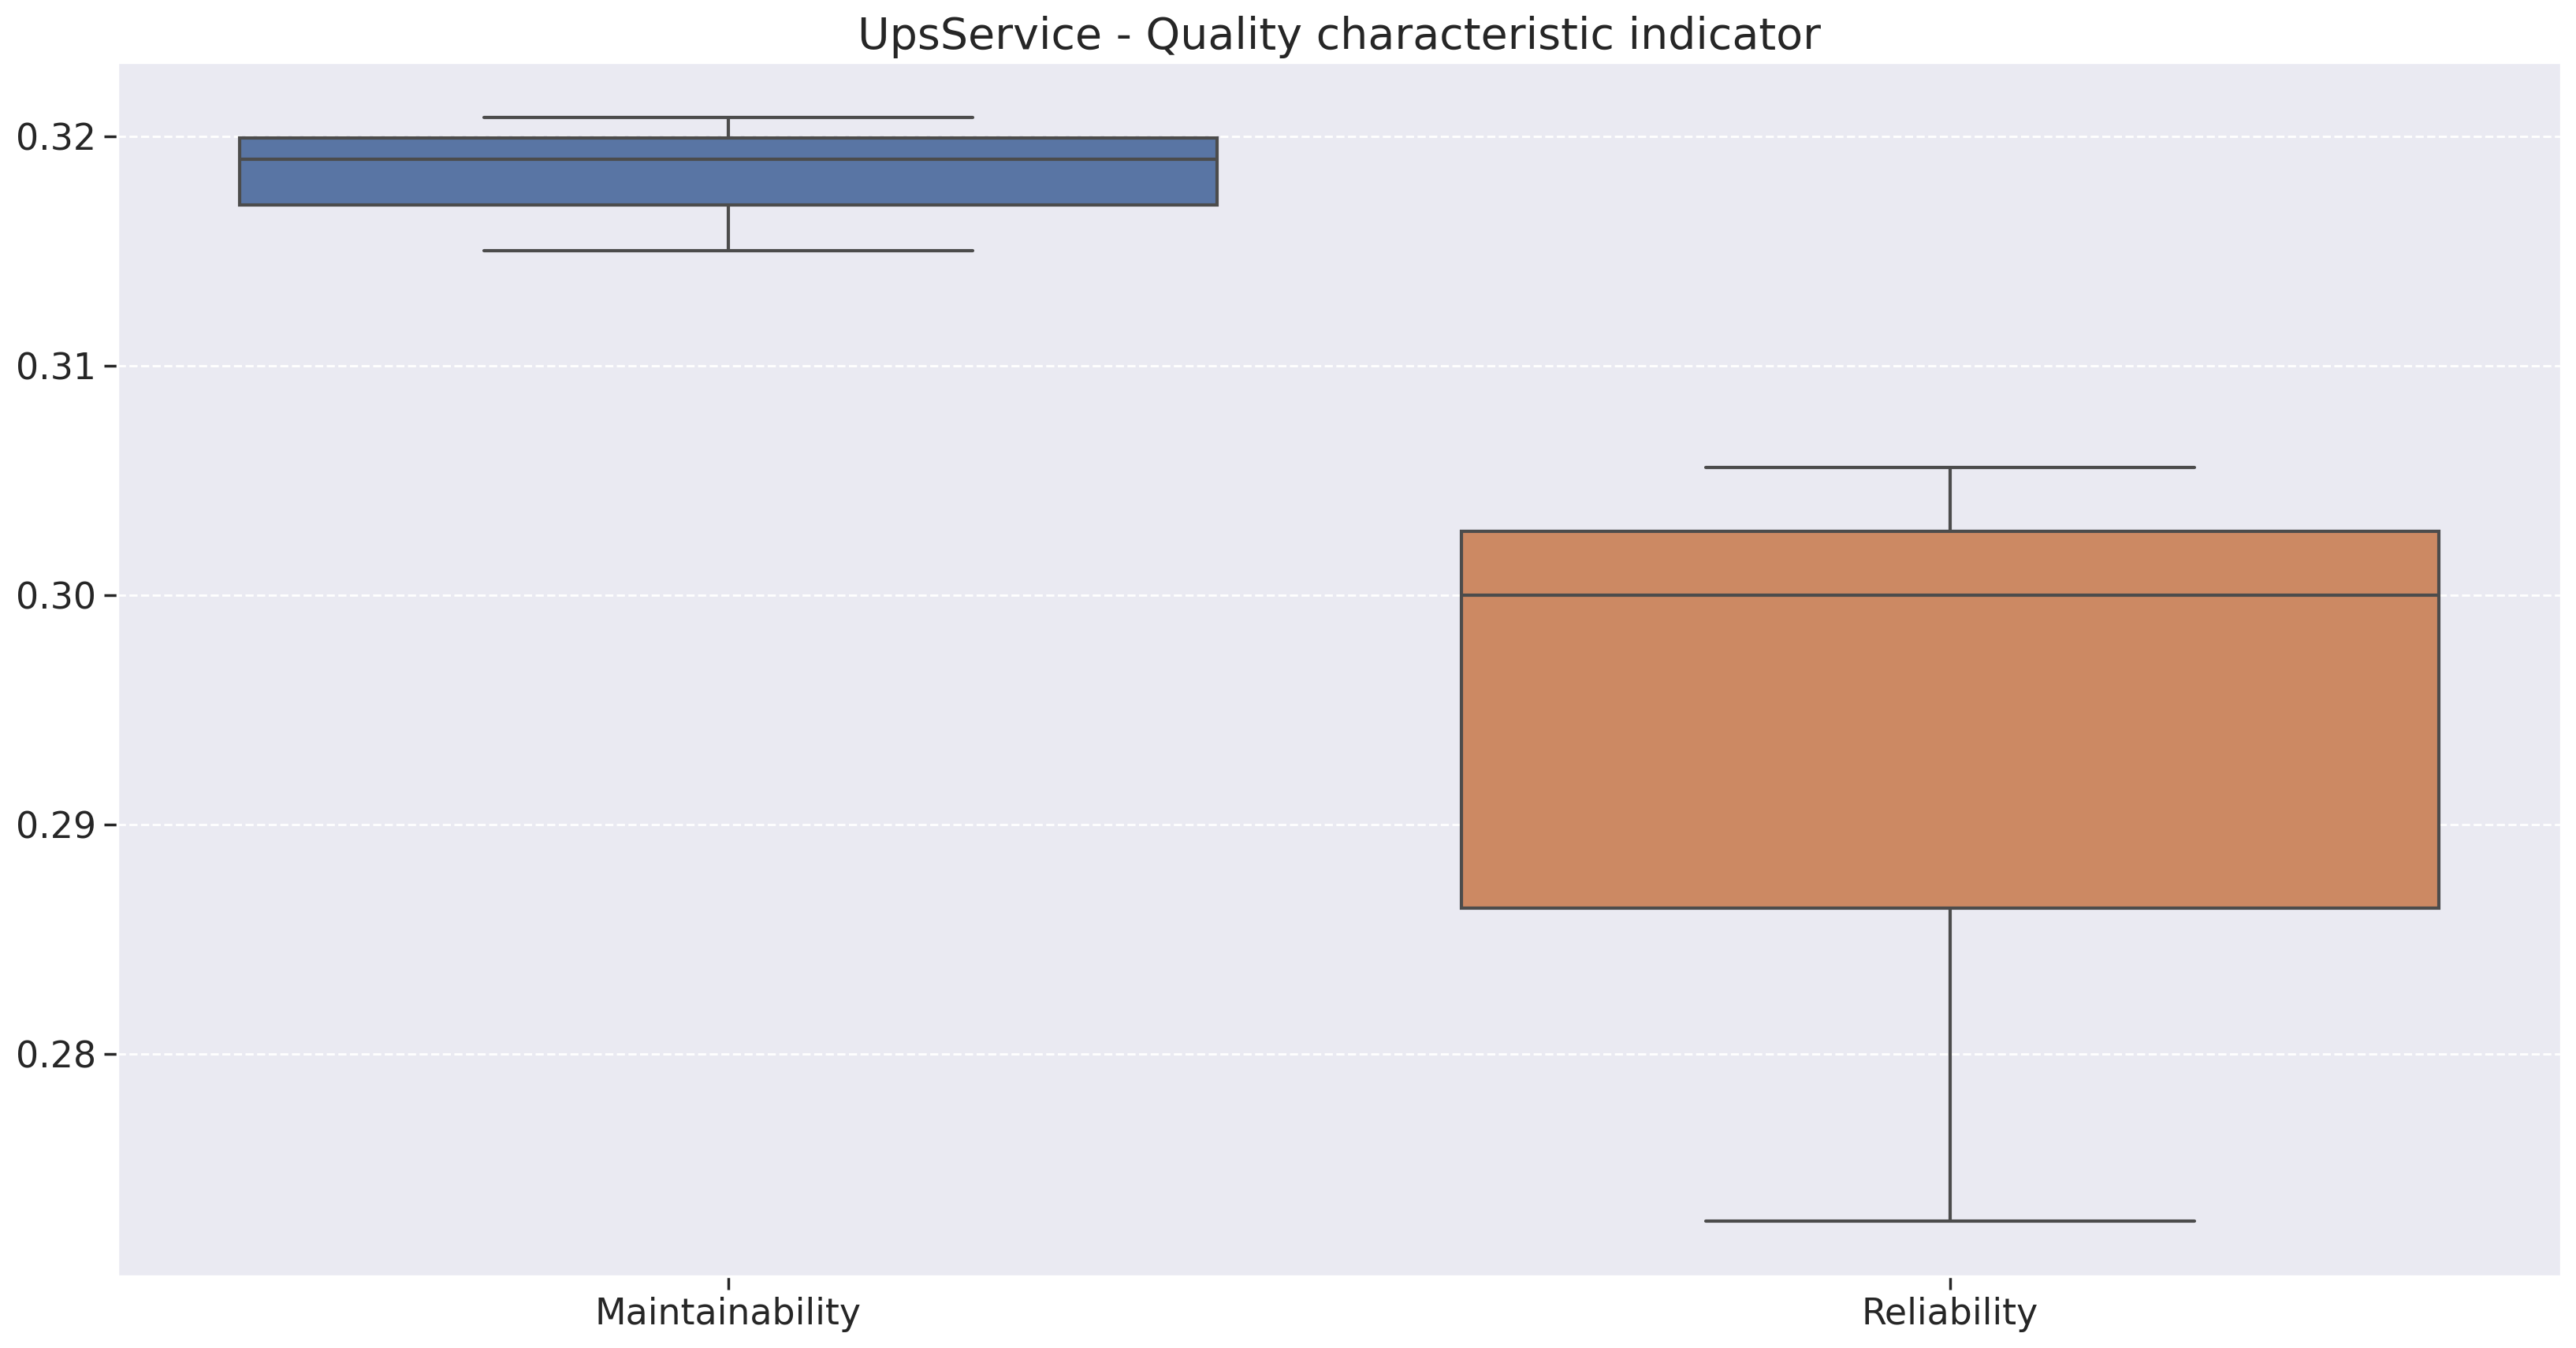

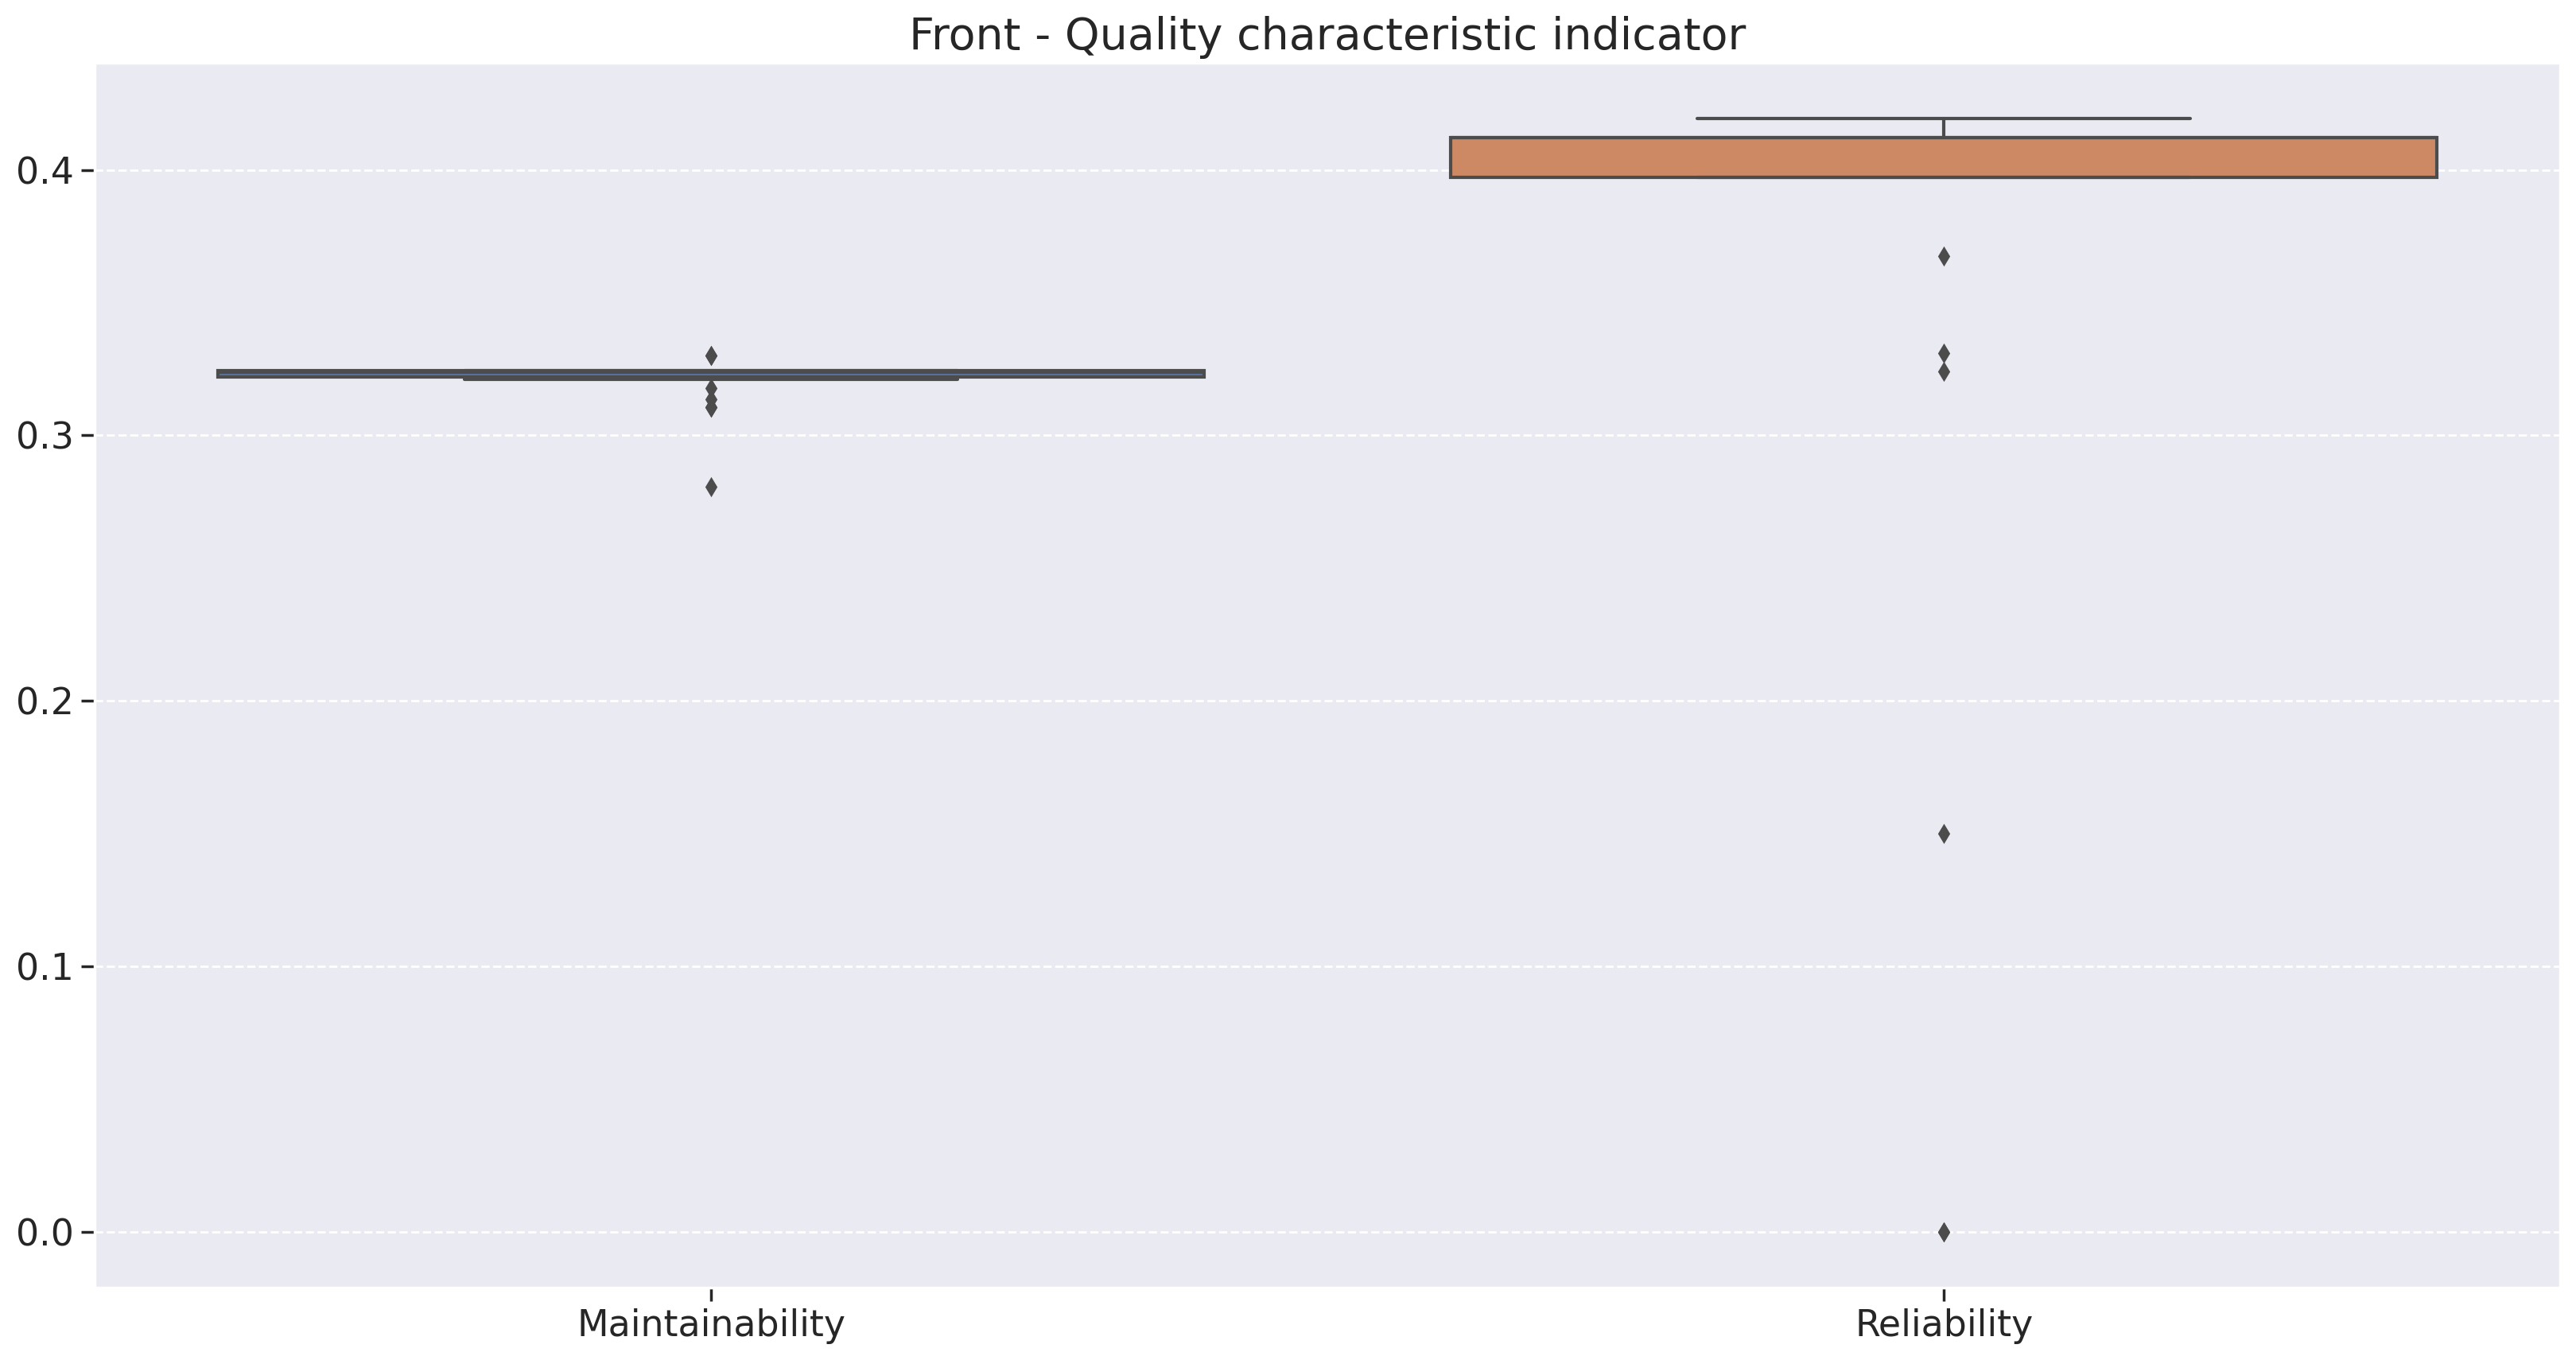

In [310]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

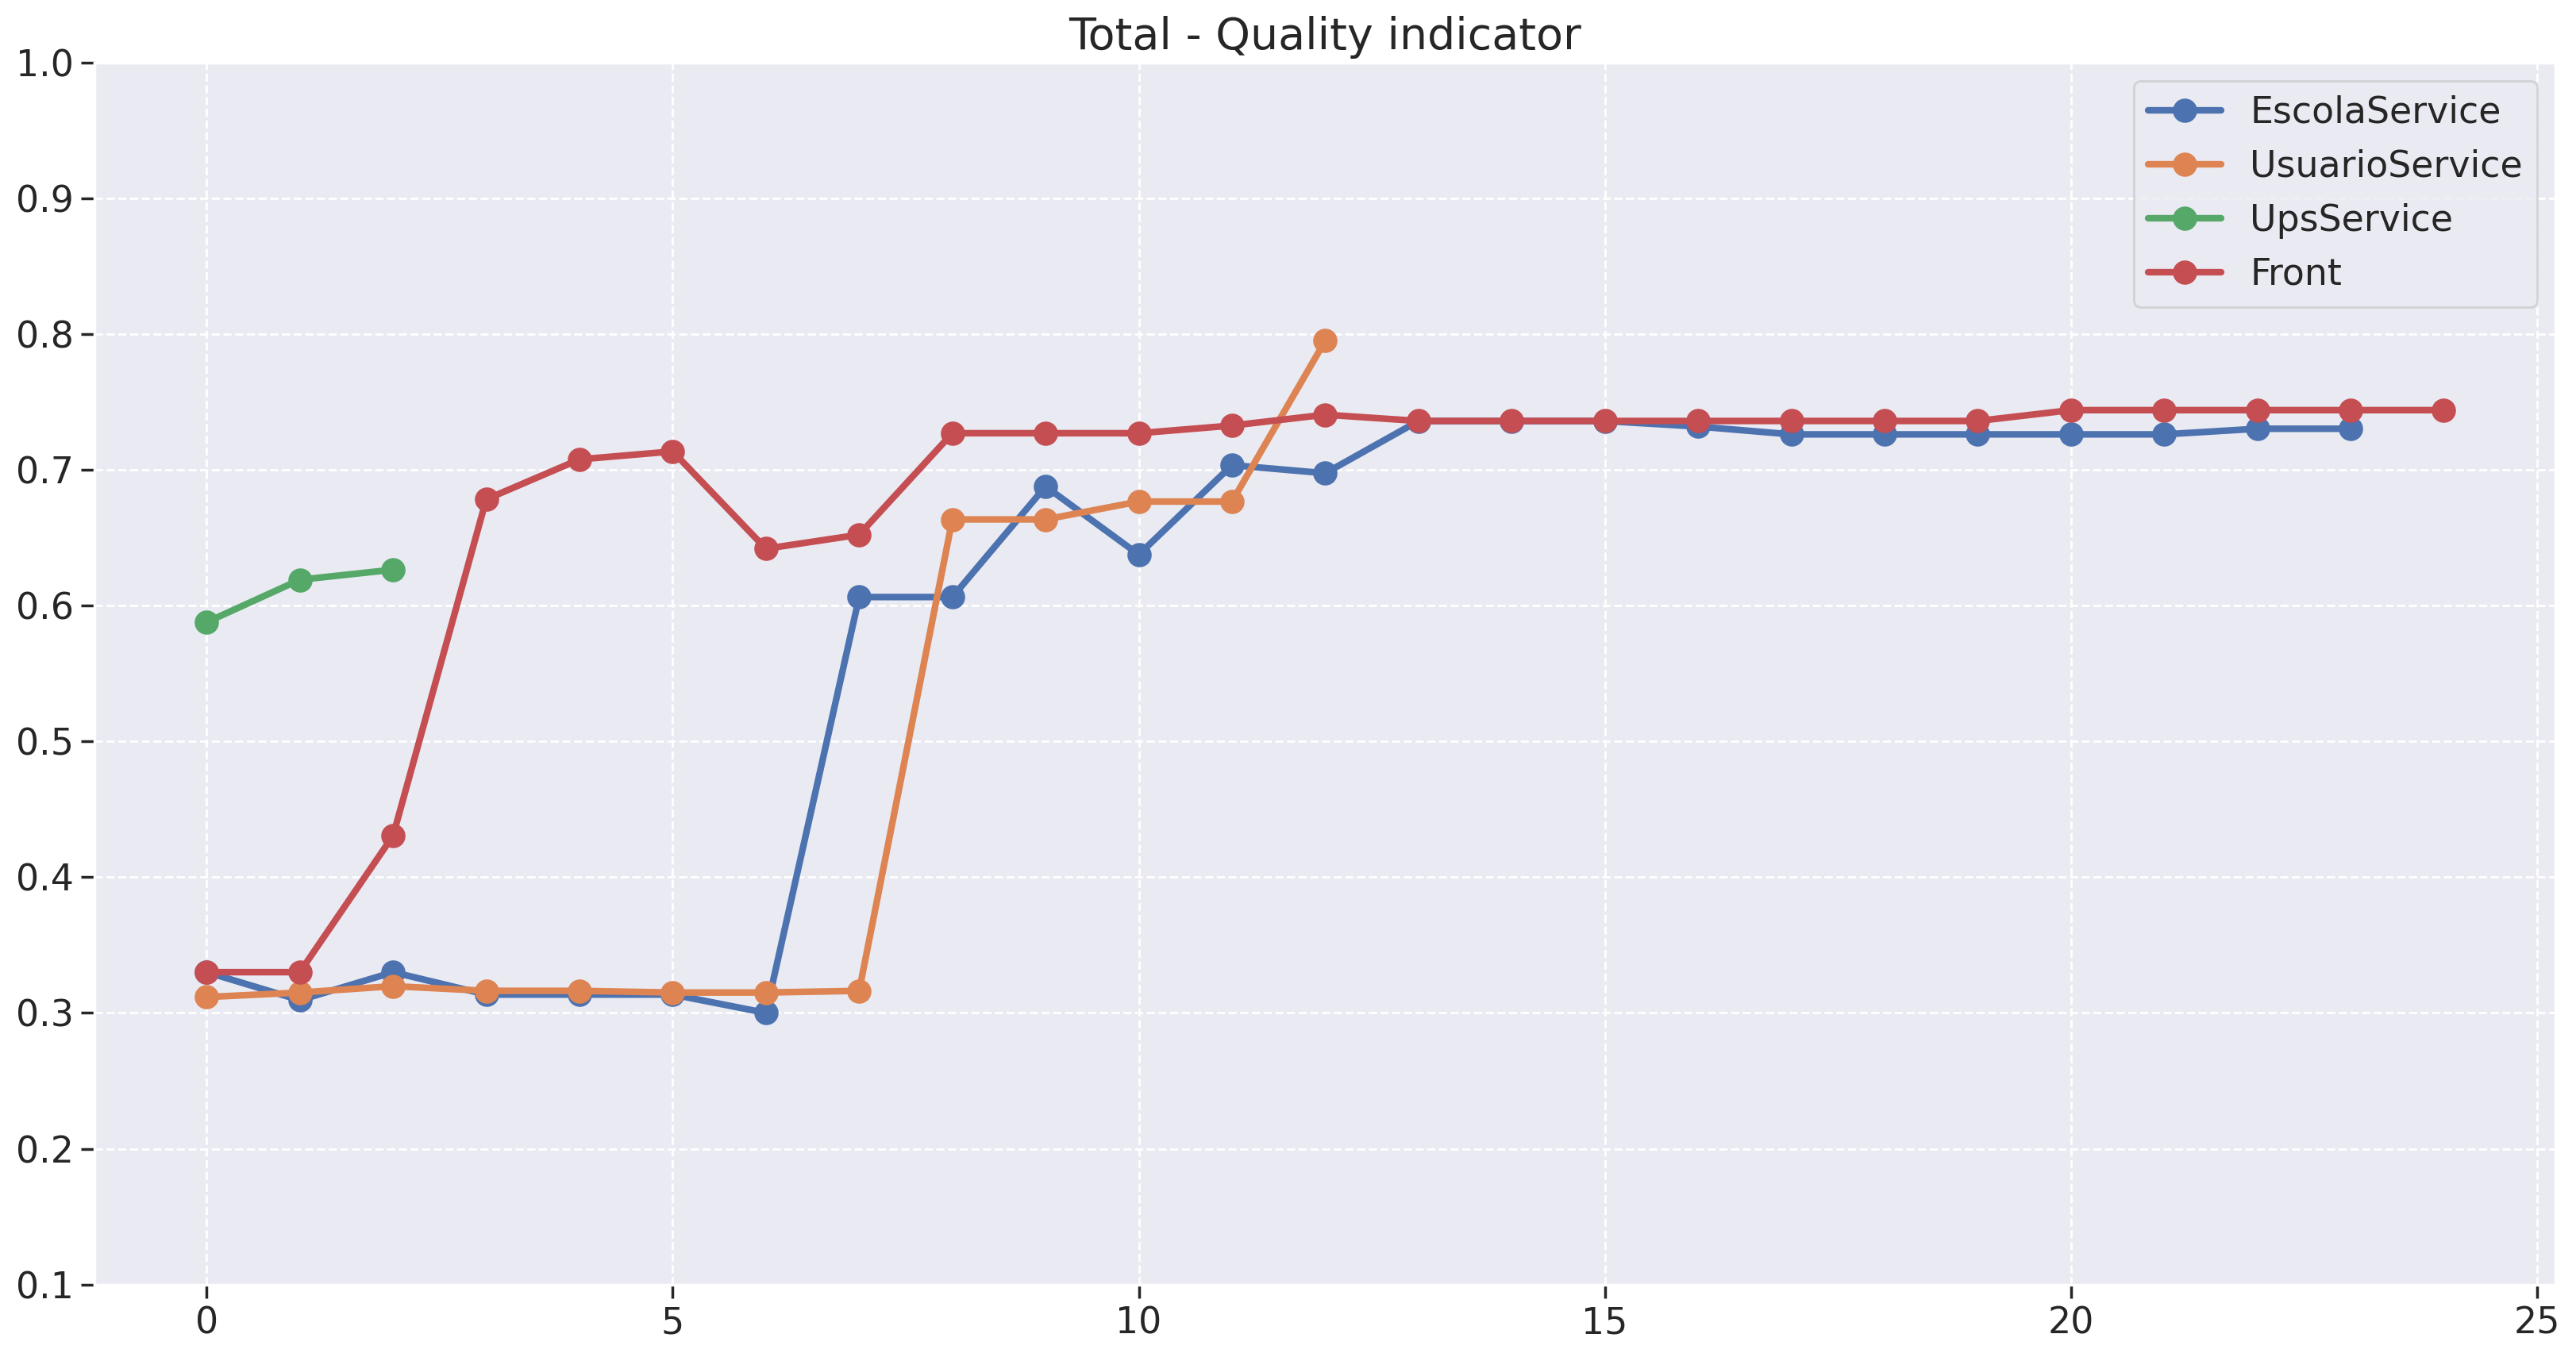

In [311]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [312]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2023-1-Dnit--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2023-1-Dnit--{}.csv'.format(current_datetime), index = False)

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,fga-eps-mds-2023-1-Dnit-EscolaService,06-04-2023-14-04-20,90,0.660000,0.000000,0.330000,0.000000,0.330000
1,0.875000,0.000000,1.000000,0.000000,0.0,0.000000,fga-eps-mds-2023-1-Dnit-EscolaService,06-12-2023-15-19-39,792,0.618750,0.000000,0.309375,0.000000,0.309375
2,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,fga-eps-mds-2023-1-Dnit-EscolaService,06-13-2023-19-54-47,633,0.660000,0.000000,0.330000,0.000000,0.330000
3,0.900000,0.000000,1.000000,0.000000,0.0,0.000000,fga-eps-mds-2023-1-Dnit-EscolaService,06-14-2023-22-56-24,1095,0.627000,0.000000,0.313500,0.000000,0.313500
4,0.900000,0.000000,1.000000,0.000000,0.0,0.000000,fga-eps-mds-2023-1-Dnit-EscolaService,06-18-2023-11-49-26,1145,0.627000,0.000000,0.313500,0.000000,0.313500
5,0.900000,0.000000,1.000000,0.000000,0.0,0.000000,fga-eps-mds-2023-1-Dnit-EscolaService,06-18-2023-20-20-58,1206,0.627000,0.000000,0.313500,0.000000,0.313500
6,0.909091,0.000000,0.909091,0.000000,0.0,0.000000,fga-eps-mds-2023-1-Dnit-EscolaService,06-18-2023-20-21-42,1304,0.600000,0.000000,0.300000,0.000000,0.300000
7,0.937500,0.000000,0.937500,1.000000,1.0,0.187500,fga-eps-mds-2023-1-Dnit-EscolaService,06-18-2023-20-22-25,1410,0.618750,0.593750,0.309375,0.296875,0.606250
8,0.937500,0.000000,0.937500,1.000000,1.0,0.187500,fga-eps-mds-2023-1-Dnit-EscolaService,06-25-2023-20-07-53,1410,0.618750,0.593750,0.309375,0.296875,0.606250
9,0.958333,0.000000,1.000000,1.000000,1.0,0.458333,fga-eps-mds-2023-1-Dnit-EscolaService,06-26-2023-00-45-53,2008,0.646250,0.729167,0.323125,0.364583,0.687708


**1) No  microsserviço de backend que apresentar o pior indicador de manutenibilidade indique qual(is) o(s) módulos/arquivos mais críticos e explique como seu time tratou esse problema.**

Após realizar uma análise dos repositórios, chegamos à conclusão de que os microsserviços do backend possuem níveis de manutenibilidade semelhantes. No entanto, identificamos que o microsserviço EscolaService apresenta a pior manutenibilidade. Isso se deve ao fato de haver duplicações no repositório EscolaService, mais especificamente nos arquivos Escola.cs e EscolaCorreta.cs, que estão localizados no módulo 'dominio'.

Para melhorar a manutenibilidade do microsserviço, é necessário corrigir a duplicação de código no módulo de 'dominio', aumentar a presença de comentários explicativos e reduzir a complexidade ciclomática.

**2) No microsserviço que apresentar o pior indicador de confiabilidade, explique como seu time tratou esse problema.**

Foi identificado que o microsserviço UsuarioService apresentava o pior indicador de confiabilidade devido ao desenvolvimento tardio dos testes. Esse atraso ocorreu devido à falta de familiaridade dos membros da equipe com  testes em C#, exigindo uma certa curva de aprendizado para dominar testes nessa linguagem e passar o conhecimento para o resto da equipe. No entanto, esse problema foi solucionado com o aprendizado de teste em C#, resultando em um aumento progressivo na cobertura, que atingiu 83% ao final do desenvolvimento.

**3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do desenvolvimento, do projeto relacionado ao seu time.**

Inicialmente, a qualidade dos microsserviços era baixa devido à falta de implementação dos testes, resultado da inexperiência da equipe nessa área. No entanto, à medida que o desenvolvimento prosseguia e a equipe ganhava mais experiência na elaboração de testes, a qualidade do produto entregue aumentava.

No repositório do front-end, houve uma falha na comunicação durante o início do projeto, o que resultou na falta de preparo da equipe para lidar com a construção de testes. Como resultado, alguns pull requests foram mesclados no projeto sem uma boa implementação e cobertura de testes. No entanto, essa situação foi corrigida nas sprints subsequentes, como evidenciado pela recuperação posterior. Devido à baixa complexidade ciclomática, pouca duplicação e boa cobertura de código apresentada ao longo do projeto, o aspecto geral tem um bom nível de qualidade.

O microsserviço UsuarioService teve uma qualidade inicial baixa, pois foi o primeiro a ter funcionalidades desenvolvidas e a equipe possuía pouca maturidade na criação de testes. No entanto, observa-se que o indicador de qualidade aumentou significativamente nas entregas mais recentes, à medida que a cobertura de testes foi ampliada, sem apresentar complexidade excessiva ou duplicação.

No microsserviço EscolaService, em geral, observa-se um aumento no indicador de qualidade, com algumas pequenas quedas que ocorreram por conta da priorização do desenvolvimento das funcionalidades em detrimento à qualidade do código. Além disso, há uma leve queda no final do projeto devido à introdução de duplicação no código. Isso ocorreu por conta do aumento do fluxo de entregas, o que impactou na qualidade do código.

Diferente dos outros microsserviços, o UpsService já iniciou com uma qualidade mais elevada, pois foi desenvolvido apenas nas últimas semanas do projeto, quando a equipe já possuía uma boa maturidade na criação de testes e no desenvolvimento de forma geral.